<a href="https://www.kaggle.com/code/ryanbouchou/eeg-classification?scriptVersionId=246277163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification d'imageries motrices
Date : 13 juin 2025

## Introduction et objectifs

### Contexte scientifique
Les *signaux électroencéphalogramme (EEG)* sont des enregistrement de l'activité cérables, capté grâce à des électrodes disposées sur le cuir chevelu. L'*imagerie motrice* (IM) consiste donc en la captation des signaux propre à la visualisation d'actions motrices par le sujet, ici, des mouvements de la main gauche ou droite, des pieds, ou encore de la langue. La classification de ces IM à partir de signaux EEG constitue un défi majeur en neurotechnologie, avec des applications directes dans les *interfaces cerveau-machine (BCI)*.


### Signaux EEG
Aujourd'hui, le champs des neurosciences et des neurotechnologiques dédié à l'IM connaît un fort développement de par les potentialités révélées par les *réseaux de neurones*. Et pour cause, les signaux EEG étaient jusqu'alors difficilement exploitables de par leur nature intrinsèquement **stochastique, non-stationnaire** et d'un **faible rapport signal/bruit**. 

En effet, on dénombre de multiples sources de bruit qui impactent les observations:
- **Environnementalse** : Champ electromagnétiques, bruit engendré par la ligne électrique, etc.
- **Instrumentales** : OEM, capteurs, appareils utilisés, etc.
- **Biologiques** : Mouvements oculaires (*OEG*), battements cardiaques, activité musculaire, etc.


### Objectifs
- **Objectif principal** : Développer un système de classification robuste pour 4 classes d'imageries motrices
- **Objectifs secondaires** :
    1. Évaluer l'impact de différentes techniques de prétraitement
    2. Comparer plusieurs architectures de réseaux de neurones
    3. Optimiser les hyperparamètres, et la pertinence du modèle
    4. Analyser la contribution des différentes bandes de fréquences
- **Objectifs personnels** :
    1. Découvrir le champ des neurosciences computationnelles
    2. Premiers pas en intelligence artificielle pratique (TensorFlow, Keras, MNE...)
    3. Lecture et synthèse d'articles scientifiques 

## État de l'art
Historiquement, des méthodes comme les *motifs spatiaux communs (CSP - Common Spatial Patterns)*, la *densité spectrale de puissance (PSD - Power Spectral Density)* et la *transformée en ondelettes (WT - Wavelet Transform)* étaient utilisées. Cependant, ces aspects procéduraux sont au détriment de la composante temporelle ; ce qui, étant la nature profondemment temporelle des EEG, conduit à une perte d'information dommageable...

De plus, les données pouvant être très volumineuse, l'*analyse en composantes principales (PCA)* est souvent utilisée pour réduire la dimension du jeu de donnée. Cette dernière permet, dans le contexte des réseaux de neurones, un apprentissage plus rapide tout en évitant sur surapprentissage.

Désormais, les algorithmes de deep learning sont capables d'extraire des caractéristiques multiples (à savoir temporelles et fréquentielles) sans avoir négliger l'une, ou l'autre ; et ce, sans grand prétraitement en amont.

## Hypothèses à mettre en oeuvre
1.  La combinaison domaine temporel + fréquentiel améliore la classification
2.  L'augmentation de données par fenêtrage glissant augmente la robustesse
4.  Les architectures hybrides (CNN+RNN) surpassent les approches simples
5.  La normalisation par winsorisation + z-score optimise les performances

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft, rfftfreq
from scipy.stats.mstats import winsorize
from scipy.signal import welch
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import random


2025-06-19 05:52:50.365522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750312370.716163      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750312370.816601      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Utilitaires
Dans un soucis de modularité, en dépit du format très linaire des notebooks, on élabore quelques fonctions utiles permettant, entre autre, d'évaluer un modèle, de réaliser des affichages, etc.

In [2]:
def training_bahaviour(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("training_plot.png")
    plt.show()

In [3]:
def evaluate_model(model, X_test, y_test, label_encoder, model_name = None):    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    title = '' if model_name == None else ' | ' + model_name
    
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro')
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title(f'Matrice de Confusion' + title)
    axes[0].set_xlabel('y_pred')
    axes[0].set_ylabel('y_true')
    
    report = classification_report(y_true, y_pred, 
                                 target_names=label_encoder.classes_, 
                                 output_dict=True)
    report_df = pd.DataFrame(report).transpose().iloc[:-3, :-1]
    sns.heatmap(report_df.astype(float), annot=True, fmt='.3f', 
                cmap='YlOrRd', ax=axes[1])
    axes[1].set_title(f'Métriques par classe' + title)
    
    plt.tight_layout()
    plt.show()
    
    return metrics, report_df

## Métriques de performance
### F1-Ccore
Sert à évaluer la performance globale d’un modèle, surtout quand les classes sont déséquilibrées. Un bon F1-score indique que le modèle est à la fois précis (peu de faux positifs) et complet (peu de faux négatifs).

> **Définition** : Moyenne harmonique entre précision et rappel, pour équilibrer les deux.
$$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### Recall
Plus le recall est élevé, moins le modèle oublie de vrais cas positifs.

> **Définition** : Parmi tous les éléments réellement positifs, combien ont été correctement prédits comme positifs.
$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$\frac{\text{Precision} \dot \text{Recall}}{\text{Precision} + \text{Recall}}$$



# Analyse exploratoire
La démarche première du *data scientist*, où de l'*ingénieur ML* est de prendre connaissance en profondeur de son (ses) outil(s) de travail ! Dans cette section, on s'intéresse au jeu de donnée **BCI IV 2.a** (duquel ont préalablement été extrait les événements moteurs).

***Remarque**: Les jeux de données en IM sont malheureusement assez rares ; de par la complexité à réaliser ces expériences, l'écosystème de la recherche, l'aspect "propriétaire" des données, etc. Heureusement, des collectifs d'universités et laboratoires de recherches ont mis en oeuvre une politique communautaire forte pour rescencer ces jeux de données, tandis qu'on compte des acteurs majeurs comme BCI*.

## Chargement et formatage
Quoique le jeu de donnée soit propre, il est de coutûme de supprimer toute donnée incomplète. Une autre stratégie serait de remplacer les caractéristiques (features) absentes par des valeurs canoniques (nulle, moyenne).

In [4]:
df = pd.read_csv("/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv")
df = df.dropna()
eeg_columns = df.columns[4:]
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
labels = df['label'].unique()

## Présentation
Dans le cas présent, toutes les enregistrements d'un même patient, pour une *epoch* donnée, constituent un même signal.

> **Epoch** : Événement daté, et symbolique, au cours de l'enregistrement. Il correspond à une action, comme par exemple le début de l'expérience, l'affichage d'un symbole auprès du cobaye, le début de visualisation motrice, etc.

In [5]:
print('-' * 40)
print("📖 Structure du data set 📖")
print(f"On dispose de {len(eeg_columns)} canaux d'enregistrement {eeg_columns}")
print(f"Les 4 labels permettant de classer les données sont : {labels}")
print('-' * 40)
print(df.head(10))
print('-' * 40)

----------------------------------------
📖 Structure du data set 📖
On dispose de 22 canaux d'enregistrement Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')
Les 4 labels permettant de classer les données sont : ['tongue' 'foot' 'right' 'left']
----------------------------------------
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   
5        1 -0.080  tongue      8  1.150619 -2.0

## Exploitabilité
Après un tour d'horizon sommaire du jeu de donnée, on interroge de façon tangible (et plutôt exhaustive ma foi) l'exploitabilité du jeu de donnée. Naturellement, l'absence de certaines features, pour certains enregistrements constitue un des critères (et donc enjeu) de l'exploitabilité du data set. Toutefois, on s'interroge aussi quant à la répartition des classes, au nombre d'enregistrement, à la qualité des valeurs...

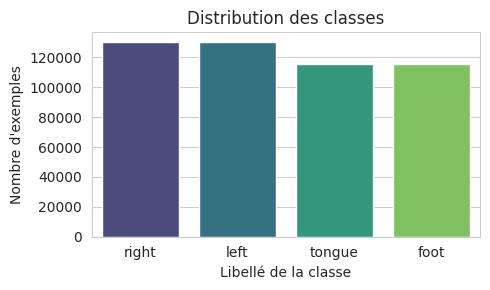

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=df, palette='viridis', order=df['label'].value_counts().index)
plt.xlabel("Libellé de la classe", fontsize=10)
plt.ylabel("Nombre d'exemples", fontsize=10)
plt.title("Distribution des classes", fontsize=12)
plt.tight_layout()
plt.show()

**Interprétation** : Ici, on constate que les classes sont représentées de façon tout à fait équilibrée ; c'est un point positif et rassurant, nous pouvons continuer ! 

***Remarque**: Un déséquilibre réprésentationnel engendre un apprentissage biaisé ; et rend le modèle inexploitable.*

### Groupement des données
Initialement, les données sont "éparpillées" ; de fait, il nous fait regrouper les amplitudes des signaux selon l'*epoch* qu'elles modélisent.

In [7]:
epochs = df.groupby('epoch')
x, y = [], []

target_length = 201

for i, epoch in epochs:
    data = epoch[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    x.append(data)
    y.append(epoch['label'].iloc[0])
    
x = np.array(x)
y = np.array(y)

print(f"Dimension de x après regroupemment : {x.shape}")
print(f"Dimension de y après regroupemment : {y.shape}")

Dimension de x après regroupemment : (632, 22, 201)
Dimension de y après regroupemment : (632,)


Les données sont qualitatives, mais peut-être pas sufisamment nombreuses. On garde dans un coin de la tête qu'il va nous falloir densifier le jeu de données.

### Analyse statistique
Dans cette dynamique d'appropriation du data set, on prête attention à comprendre la représentationd des signaux, non seulement par curiosité, mais aussi pour savoir quels traitements seront réalisables sur ceux-ci. Se faire une idée de la forme est, selon toute vraissemblance, indispensable. En conséquence de quoi, on applique quelques métriques de base pour délayer un apperçu qualitatif des données dans leur ensemble.

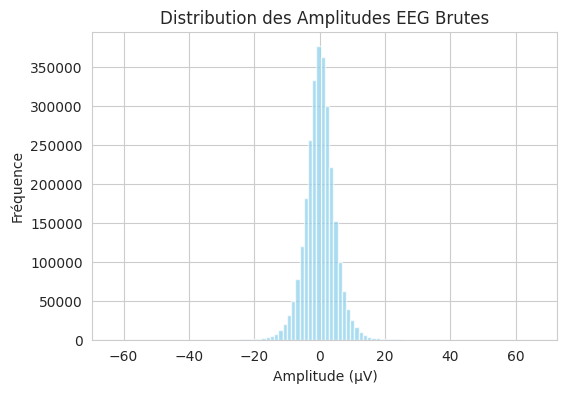

In [8]:
fig = plt.figure(figsize=(6, 4))
plt.hist(x.flatten(), bins=100, alpha=0.7, color='skyblue')
plt.title('Distribution des Amplitudes EEG Brutes')
plt.xlabel('Amplitude (μV)')
plt.ylabel('Fréquence')
plt.show()

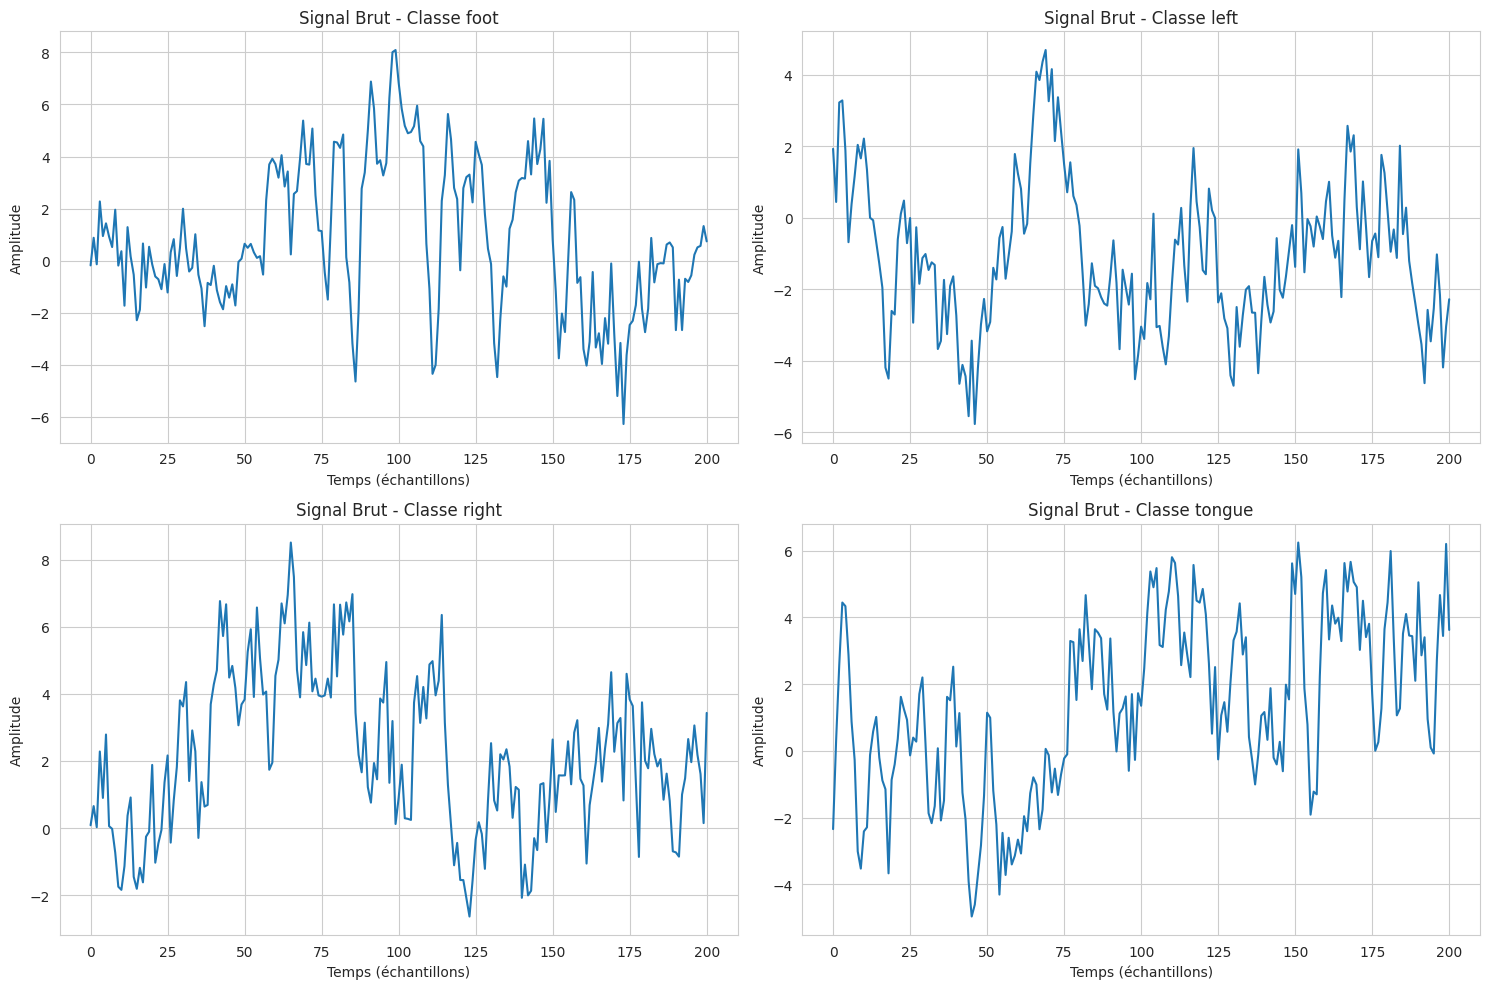

In [9]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sample_indices = {label: np.where(y == label)[0][0] for label in np.unique(y)}
for i, (label, idx) in enumerate(sample_indices.items()):
    row, col = (i//2, i%2) if i > 0 else (0, 1)
    if i == 0: row, col = 0, 0
    if i == 1: row, col = 0, 1
    if i == 2: row, col = 1, 0
    if i == 3: row, col = 1, 1
    
    axes[row, col].plot(x[idx, 10, :])  # Canal 10 comme exemple
    axes[row, col].set_title(f'Signal Brut - Classe {label}')
    axes[row, col].set_xlabel('Temps (échantillons)')
    axes[row, col].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [10]:
stats_raw = {
    'mean': np.mean(x),
    'std': np.std(x),
    'min': np.min(x),
    'max': np.max(x),
    'outliers_5pct': np.percentile(x, 5),
    'outliers_95pct': np.percentile(x, 95)
}

results_1 = f"Moyenne: {stats_raw['mean']:.3f}\n Écart-type: {stats_raw['std']:.3f}\n Range: [{stats_raw['min']:.2f}, {stats_raw['max']:.2f}]\n \
Percentiles :\n \
\t 5% : {stats_raw['outliers_5pct']:.3f}\n \
\t 95% : {stats_raw['outliers_95pct']:.3f}\n"
print(results_1)

Moyenne: -0.000
 Écart-type: 4.652
 Range: [-63.05, 66.25]
 Percentiles :
 	 5% : -7.440
 	 95% : 7.395



**Interprétation** : Au delà de l'aspect visuel des données brutes selon l'action moteur, on constate que :
- les données sont centrées ; c'est bien.
- la dynamique du signal, *i.e la bande passante*, est assez importante ; on a des amplitudes variées, comme en dénote l'écart-type.
- les valeurs extremales sont symboliques des **artefacts** présents dans les enregistrements ; et, si la majorité des données sont contenues dans $[-7.4;7.4]$, il faudra veiller à supprimer ces *outliers* existants.

Ici, on comprend la nécessité d'un prétraitement par winsorisation et normalisation.

# Pré-traitement

## Familiarisation
### Visualisation d'un enregistrement
Initialement, on dispose de l'amplitude du signal au gré du temps pour chaque canal d'enregistrement ; comme en témoigne le graphe ci-dessous. Il s'agit de la **représentation temporelle**.

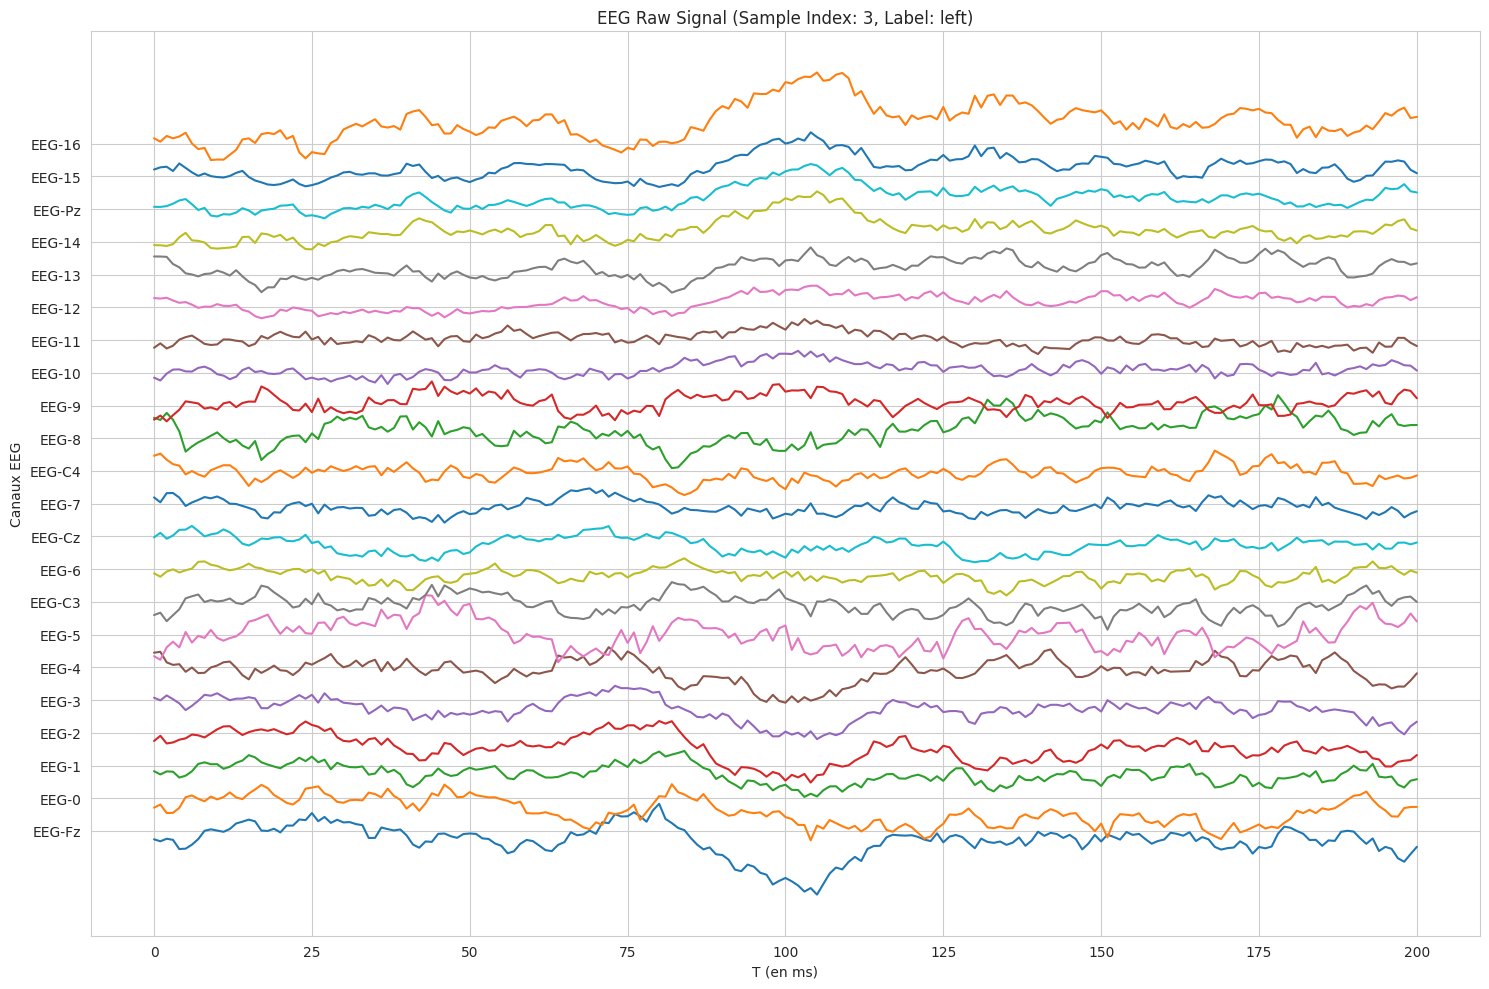

In [11]:
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0]
sample_data = x[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("T (en ms)")
plt.ylabel("Canaux EEG")
plt.grid(True)
plt.tight_layout()
plt.show()

Toutefois, si cette représentation est intéressante pour capter la dynamique temporelle globale du signal, elle n'est pas suffisante.

### Représentation temps/fréquence
Quand on s'intéresse au traitement du signal (*cf. Monsieur Wagner !)*, on apprend qu'il existe (à minima) un autre représentation possible : la représentation *fréquentielle*

Une première étape consiste à mettre en exergue "l'image" fréquentielle captée par notre EEG. Ceci est faisable à l'aide d'un spectogramme.

> **Spectrogramme.** Représentation visuelle de la distribution des fréquences d'un signal en fonction du temps.


--- Spectrogram-like EEG Heatmap ---


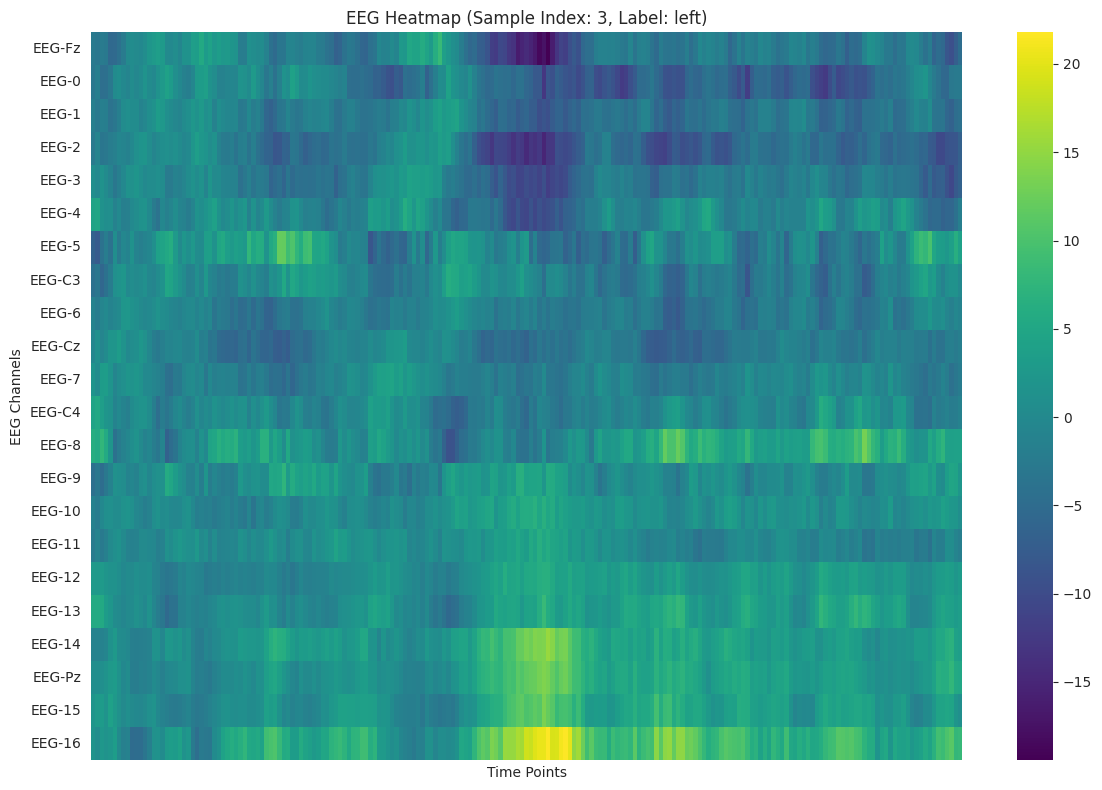

In [12]:
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

**Interprétation** On peut observer en quelque sorte l'activation fréquentielle inhérente à la captation d'une symbolique motrice particulière, en l'occurence l'imagination d'un mouvement de la main gauche.

***Remarque**: Il ne s'agit ici qu'un enregistrement parmis tant d'autre, on ne tire donc aucune conclusion quant à la zone d'activation relativement à l'IM ; par contre, on est tenté de calculé un image subsummant la réponse fréquentielle donnée à l'IM pour chaque classe*

Dans un second temps, il peut être bienvenu de calculer l'amplitude de chaque fréquence, ou bande de fréquence, pour une temporalité donné. De cette façon, on pourrait voir "quoi s'active", et quand. Pour ce faire, on calcule *transformée de Fourier à court terme (TFCT ou STFT pour "Short-Time Fourier Transform")* :
$$
\text{STFT}_x(t, \omega) = \int_{-\infty}^{+\infty} x(\tau) \, w(\tau - t) \, e^{-j \omega \tau} \, d\tau
$$

où :
\begin{cases}
x(\tau) & \text{est le signal temporel (EEG),} \\
w(\tau - t) & \text{est la fenêtre centrée en } t, \\
\omega & \text{est la fréquence angulaire,} \\
e^{-j \omega \tau} & \text{est le noyau de Fourier complexe.}
\end{cases}

> **STFT**. Représentation temps-fréquence en glissant une fenêtre $w$ le long du signal, permettant de suivre les variations fréquentielles locales.

Et pour cause, ces amplitudes peuvent ensuite être utilisées comme entrées pour un modèle IA (ex. : CNN, LSTM, SVM...).
Néanmoins, afin d'assurer un pipeline de prétraitement pertinent, on réserve l'extraction des *features* comme la STFT pour la fin.

## Normalisation

Pour des questions d'échelles, de stabilité, et de performance, il est nécessaire de normaliser les données. En effet :
1. L'information d'un canal à l'autre, d'une mesure à l'autre, prend place dans une plage de valeur inhérente à ceux-ci ; lesquelles pouvant notablement varier. Ici, la normalisation est vouée à prévenir toute démesure dans la place que pourrait prendre telle ou telle métrique. On s'assure de la **bonne équité de la représentation des variables ; et subséquemment, de leur influence sur le modèle**.
2. Par ailleurs, **l'apprentissage est à même de converger plus efficacement** si les données sont normalisées ; en évitant d'ailleurs les problèmes d'évanescence et d'explosion du gradient.
3. Enfin, comme toute information porte un bruit inhérent aux conditions expérimentales, ainsi qu'un variabilité naturelle ; la normalisation permet d'**éviter les problèmes de généralisations**.

Dans les expériences menées, la normalisation par z-score a démontré la plus haute précision par rapport à d'autres méthodes de normalisation telles que la normalisation logarithmique (log) et la normalisation min-max. Toutefois, on les expérimente malgré tout sur notre jeu de données.

### Z-Score Normalization (StandardScaler)
Elle centre les données autour de 0 avec une variance unitaire. Adaptée si les données suivent une distribution gaussienne.
$$
x_{\text{norm}} = \frac{x - \mu}{\sigma}
$$

où : $\mu = \text{moyenne}, \quad \sigma = \text{écart-type}$
### Min-Max Normalization
Cette méthode met les données à l’échelle $[0;1]$, ce qui est utile pour préserver les proportions dans les réseaux de neurones.
$$
x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

où : $x_{\min} \text{ et } x_{\max} \text{ sont les bornes du signal.}$

### Winsorized Z-Score Normalization

Avant la normalisation, les signaux de chaque électrode sont "winsorized" pour réduire les effets des valeurs aberrantes de grande amplitude. Cela implique de remplacer les valeurs d'amplitude inférieures au 5ème percentile ou supérieures au 95ème percentile par ces percentiles respectifs, car la moyenne et l'écart-type sont sensibles aux valeurs aberrantes

$$S'_{ijk} = \frac{\text{winsorize}(S_{ijk}) - \mu_{ij}}{\sigma_{ij}}$$
Où :
- $S_{ijk}$ est l'amplitude brute du signal au canal ii, essai jj, temps kk
- $\text{winsorize}(S_{ijk})$ désigne le signal après winsorisation (par exemple à 5% et 95%)
- $\mu_{ij}$ est la moyenne du signal winsorisé du canal ii pour l'essai jj
- $\sigma_{ij}$ est l’écart-type correspondant

### Robust Normalization (RobustScaler)
Elle est robuste aux valeurs aberrantes et utile lorsque la distribution est asymétrique ou contaminée.
$$
x_{\text{norm}} = \frac{x - \text{Med}(x)}{\text{IQR}(x)}
\quad \text{où : } \text{IQR}(x) = Q_3 - Q_1
$$

$\text{avec } Q_1 \text{ et } Q_3 \text{ les quartiles à 25\% et 75\%.}$

In [13]:
def apply_normalization(x, method='winsor_zscore'):
    """Applique différentes techniques de normalisation"""
    n_samples, n_channels, n_time_points = x.shape
    x_normalized = np.zeros_like(x)
    
    if method == 'zscore':
        scaler = StandardScaler()
        for i in range(n_samples):
            for ch in range(n_channels):
                signal = x[i, ch, :].reshape(-1, 1)
                x_normalized[i, ch, :] = scaler.fit_transform(signal).flatten()
    
    elif method == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        for i in range(n_samples):
            for ch in range(n_channels):
                signal = x[i, ch, :].reshape(-1, 1)
                x_normalized[i, ch, :] = scaler.fit_transform(signal).flatten()
    
    elif method == 'winsor_zscore':
        for i in range(n_samples):
            for ch in range(n_channels):
                signal = x[i, ch, :]
                signal_winsorized = winsorize(signal, limits=[0.05, 0.05])
                scaler = StandardScaler()
                x_normalized[i, ch, :] = scaler.fit_transform(signal_winsorized.reshape(-1, 1)).flatten()
    
    elif method == 'robust':
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        for i in range(n_samples):
            for ch in range(n_channels):
                signal = x[i, ch, :].reshape(-1, 1)
                x_normalized[i, ch, :] = scaler.fit_transform(signal).flatten()
    
    return x_normalized

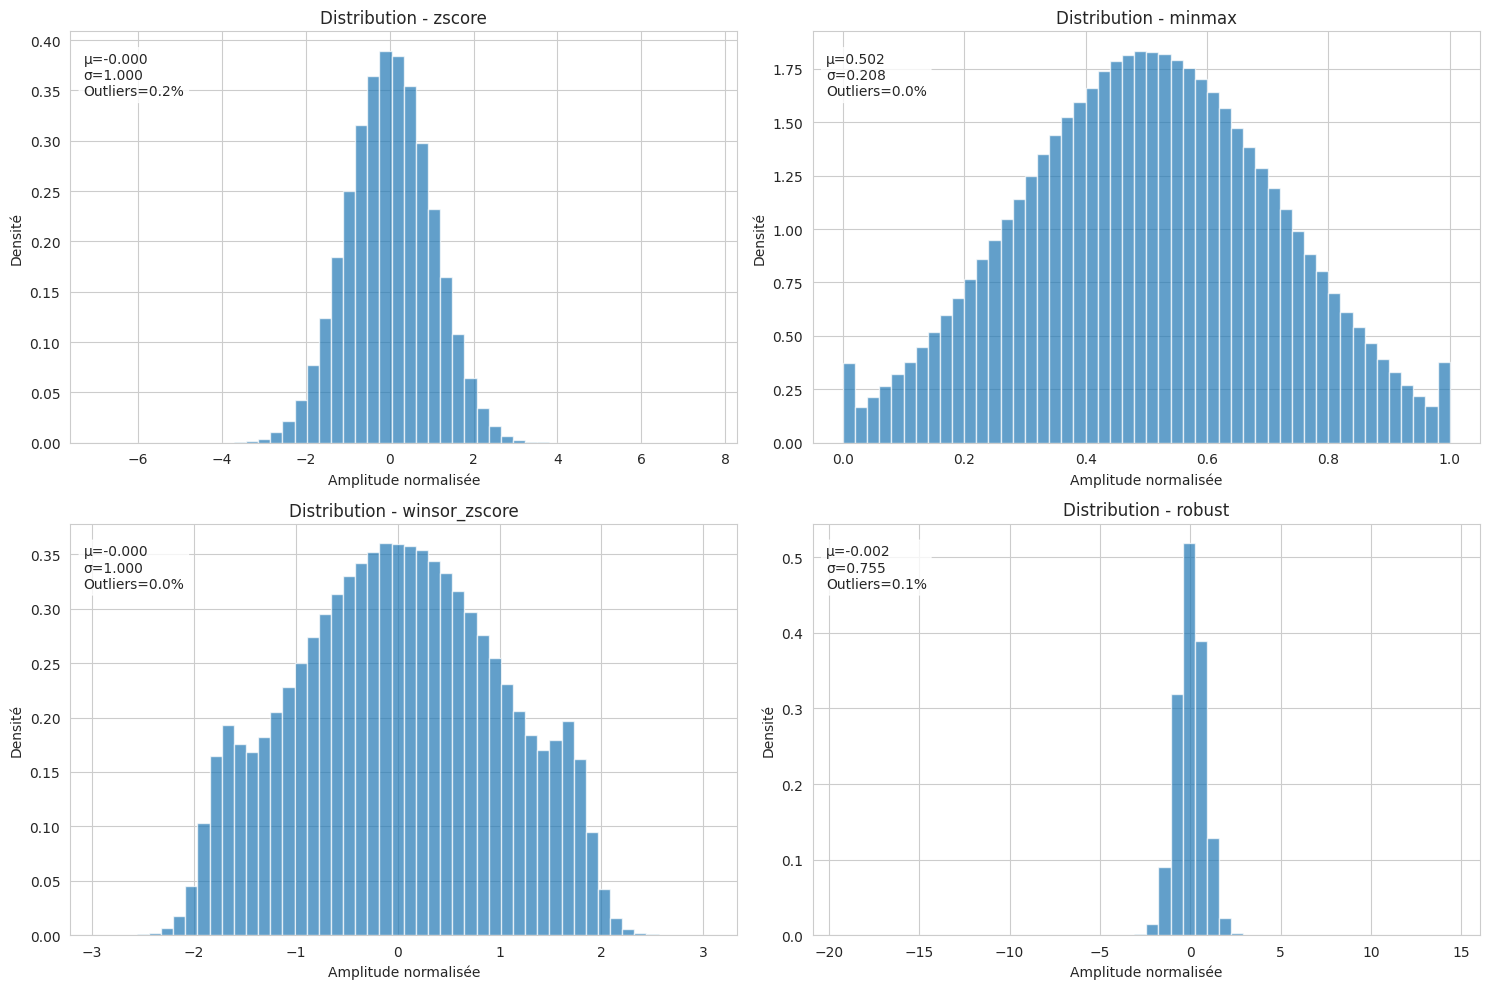

Comparaison des Techniques de Normalisation:
                 mean     std  skewness  outliers_ratio
zscore        -0.0000  1.0000    0.0704          0.0021
minmax         0.5024  0.2084    0.0141          0.0000
winsor_zscore -0.0000  1.0000    0.0737          0.0000
robust        -0.0018  0.7552    0.0528          0.0006


In [14]:
normalization_methods = ['zscore', 'minmax', 'winsor_zscore', 'robust']
normalization_results = {}

for method in normalization_methods:
    x_norm = apply_normalization(x, method)
    
    stats = {
        'mean': np.mean(x_norm),
        'std': np.std(x_norm),
        'skewness': np.mean([np.abs(np.mean(x_norm[i, ch, :]) - np.median(x_norm[i, ch, :])) 
                           for i in range(x_norm.shape[0]) 
                           for ch in range(x_norm.shape[1])]),
        'outliers_ratio': np.sum(np.abs(x_norm) > 3) / x_norm.size
    }
    
    normalization_results[method] = stats

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, method in enumerate(normalization_methods):
    x_norm = apply_normalization(x, method)
    axes[i].hist(x_norm.flatten(), bins=50, alpha=0.7, density=True)
    axes[i].set_title(f'Distribution - {method}')
    axes[i].set_xlabel('Amplitude normalisée')
    axes[i].set_ylabel('Densité')
    stats = normalization_results[method]
    axes[i].text(0.02, 0.95, f"μ={stats['mean']:.3f}\nσ={stats['std']:.3f}\nOutliers={stats['outliers_ratio']:.1%}", 
                transform=axes[i].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

comparison_df = pd.DataFrame(normalization_results).T
print("Comparaison des Techniques de Normalisation:")
print(comparison_df.round(4))

# best_method = min(normalization_results.keys(), key=lambda x: normalization_results[x]['outliers_ratio'])
# print(f"La meilleure méthode sélectionnée est : {best_method}")
best_method = 'winsor_zscore'
x_normalized = apply_normalization(x, best_method)

***Interprétation**: Ici, toutes les méthodes semblent faire l'affaire ; on note quelques sensibilités aux valeurs extrêmes, ou assymétries (skewness), mais dans l'ensemble les normalisations sont satisfaisantes. On remarque que les données sont plus ou moins écrasées dans $[0;1]$*

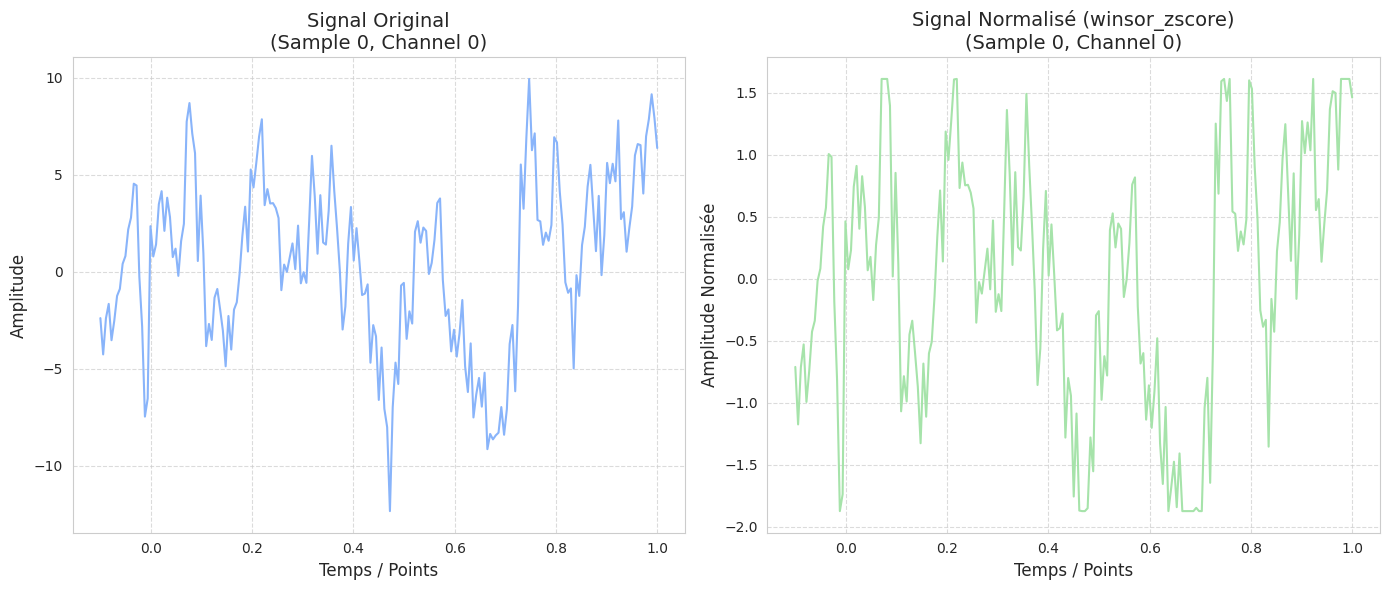

In [15]:
sample_to_plot = 0
channel_to_plot = 0
time = np.linspace(-0.1, 1, target_length)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) 
plt.plot(time, x[sample_to_plot, channel_to_plot, :], color='#89B4FA')
plt.title(f'Signal Original\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2) 
plt.plot(time, x_normalized[sample_to_plot, channel_to_plot, :], color='#A6E3AA') 
plt.title(f'Signal Normalisé ({best_method})\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude Normalisée', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 [Text(0, 0.5, 'Ch EEG-Fz'),
  Text(0, 1.5, 'Ch EEG-0'),
  Text(0, 2.5, 'Ch EEG-1'),
  Text(0, 3.5, 'Ch EEG-2'),
  Text(0, 4.5, 'Ch EEG-3'),
  Text(0, 5.5, 'Ch EEG-4'),
  Text(0, 6.5, 'Ch EEG-5'),
  Text(0, 7.5, 'Ch EEG-C3'),
  Text(0, 8.5, 'Ch EEG-6'),
  Text(0, 9.5, 'Ch EEG-Cz'),
  Text(0, 10.5, 'Ch EEG-7'),
  Text(0, 11.5, 'Ch EEG-C4'),
  Text(0, 12.5, 'Ch EEG-8'),
  Text(0, 13.5, 'Ch EEG-9'),
  Text(0, 14.5, 'Ch EEG-10'),
  Text(0, 15.5, 'Ch EEG-11'),
  Text(0, 16.5, 'Ch EEG-12'),
  Text(0, 17.5, 'Ch EEG-13'),
  Text(0, 18.5, 'Ch EEG-14'),
  Text(0, 19.5, 'Ch EEG-Pz'),
  Text(0, 20.5, 'Ch EEG-15'),
  Text(0, 21.5, 'Ch EEG-16')])

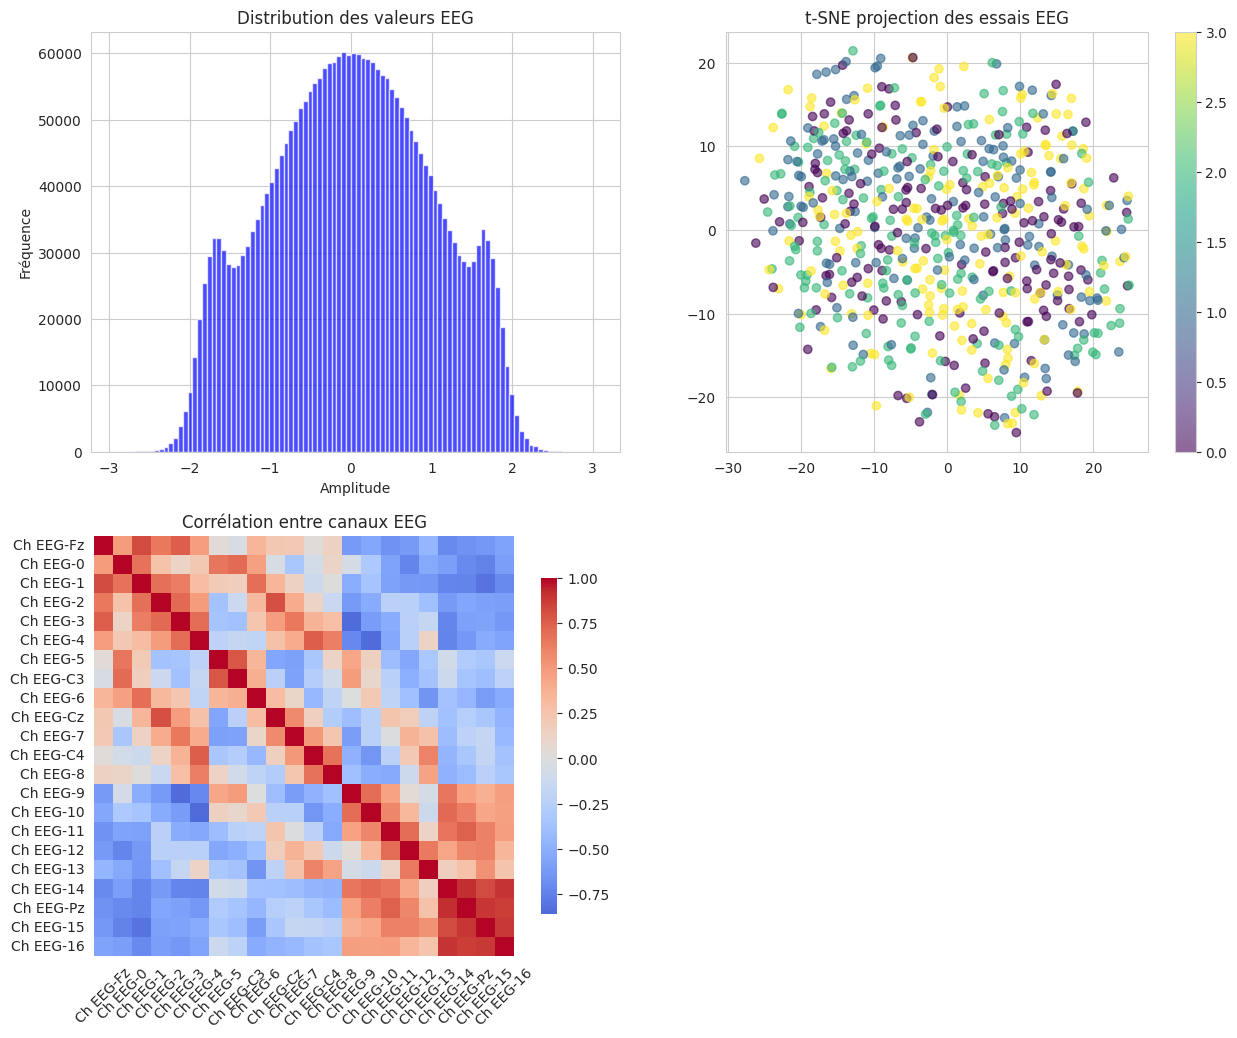

In [16]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.hist(x_normalized.flatten(), bins=100, alpha=0.7, color='blue')
plt.title("Distribution des valeurs EEG")
plt.xlabel("Amplitude")
plt.ylabel("Fréquence")

plt.subplot(2, 2, 2)
X_flat = x_normalized.reshape(x_normalized.shape[0], -1)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_flat)
label_encoder = LabelEncoder()
yn_encoded = label_encoder.fit_transform(y)
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=yn_encoded, cmap='viridis', alpha=0.6)
plt.title("t-SNE projection des essais EEG")
plt.colorbar(scatter)

plt.subplot(2, 2, 3)
sample_data = x_normalized[0] 
corr_matrix = np.corrcoef(sample_data)
ch_names = [f'Ch {eeg_columns[ch]}' for ch in range(22)]
sns.heatmap(corr_matrix, 
           xticklabels=ch_names[:len(sample_data)], 
           yticklabels=ch_names[:len(sample_data)],
           cmap='coolwarm', center=0, 
           square=True, cbar_kws={'shrink': 0.8})
plt.title("Corrélation entre canaux EEG")
plt.xticks(rotation=45)
plt.yticks(rotation=0)


**Synthèse** :

| Aspect                   | Interprétation                                                                  |
| ------------------------ | ------------------------------------------------------------------------------- |
| Distribution             | Bonne normalisation (Z-score), avec quelques motifs récurrents                  |
| t-SNE                    | Les classes sont mélangées, donc difficilement séparables sans feature learning |
| Corrélation inter-canaux | Redondance présente, exploitable via réduction ou spatial filtering (CSP)       |

**Réflexion** : En l'état, on ne tire pas partis de ces mesures ; mais on fait un état des lieux des données post-normalisation. Ce que je me dis, c'est qu'il semble y avoir des corrélation entre certains canaux EEG ; qu'il y a une corrélation locale d'un point de vu spatial (entre canaux proches) et que pour le moment les données ne sont clairement pas linéairement séparables

**À envisager** :
* Réduction de la dimensionnalité (ICA, PCA, fusion de canaux...)
* Vecteur de matrices de corrélation (une pour chaque essai) à classifier
* Corrélation entre canaux selon la classe ? Détecter des différences de structure fonctionnelle du cerveau entre classes, à partir des corrélations entre canaux EEG.

## Représentation fréquentielle - DFT
On extrait la composante fréquentielle de nos données dans l'optique de convoluer dessus avec notre CNN. Ce nous sera utile si on souhaite filtrer certaines composantes, sachant que ce sont les bandes de fréquence cérébrale $\alpha$ et $\beta$ qui sont en particulier représentatives de l'IM. Comme nos signaux sont discret, on utilise la transformée de Fourier discète (DFT en anglais), dont on donne l'expression suivante :

\begin{equation}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-2\pi i \frac{kn}{N}}, \quad k = 0, 1, \dots, N-1
\end{equation}
où :
- $x_n$ : valeur du signal au temps discret $n$.
- $X_k$ : coefficient fréquentiel correspondant à la fréquence discrète $k$.
- $N$ : nombre total d'échantillons du signal (longueur de la fenêtre ou du signal complet).
- $e^{-2\pi i \frac{kn}{N}}$ : noyau complexe de la transformée, représentant une rotation dans le plan complexe.
- $k$ : indice de la fréquence, varie de $0$ à $N-1$.
- $n$ : indice temporel, varie de $0$ à $N-1$.

Comme le signal est réel, il a une propriété de symétrie dont on peut s'épargner le stockage => on ne conserve que les fréquences positives ; et on réduit la dimension pour éviter de surcharger l'apprentissage.

In [17]:
n_samples, n_channels, n_time_points = x_normalized.shape
x_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(x_normalized[i, ch, :])
        x_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

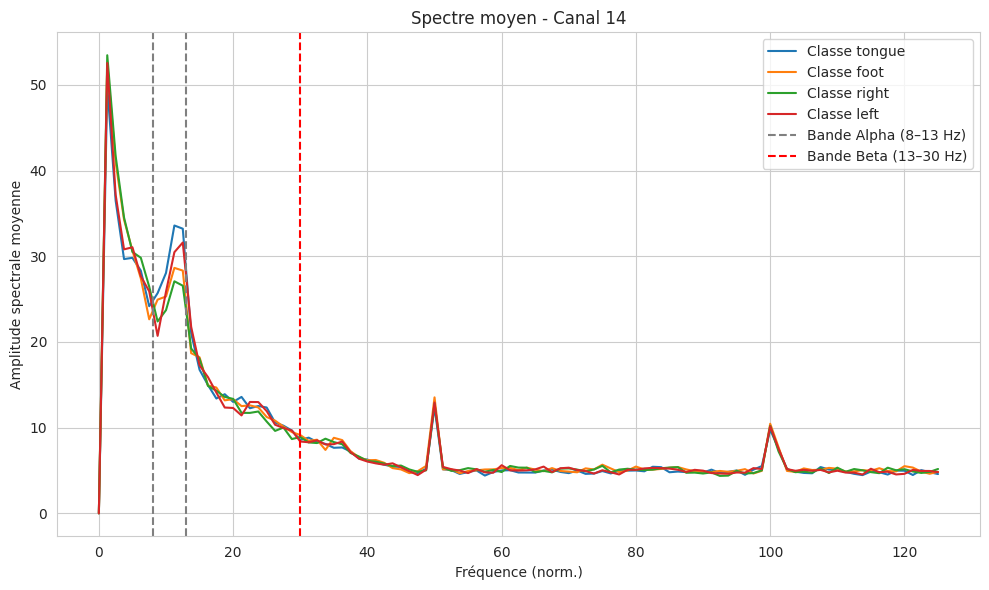

In [18]:
mean_spectra_per_class = []
for cls in labels:
    class_indices = np.where(y == cls)[0]
    class_mean_spectrum = x_freq[class_indices].mean(axis=0)  # Moyenne sur les échantillons
    mean_spectra_per_class.append(class_mean_spectrum)

channel_to_plot = 14
freqs = np.linspace(0, 250 / 2 , 101)
plt.figure(figsize=(10, 6))
for i, cls in enumerate(labels):
    plt.plot(freqs, mean_spectra_per_class[i][channel_to_plot], label=f"Classe {cls}")
plt.xlabel("Fréquence (norm.)")
plt.ylabel("Amplitude spectrale moyenne")
plt.title(f"Spectre moyen - Canal {channel_to_plot}")
plt.axvline(8, color='gray', linestyle='--', label='Bande Alpha (8–13 Hz)')
plt.axvline(13, color='gray', linestyle='--')
plt.axvline(30, color='red', linestyle='--', label='Bande Beta (13–30 Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***Remarque**: On observe un pic d'amplitude aux basses fréquences ; ce qui a de quoi dénoter de la partialité du pré-traitement, de par la persistance d'artéfacts (clignements d'yeux, etc.)*

## Augmentation des données
Afin d'assurer un apprentissage pertinent, dont le modèle résultant à la capacité de *généraliser*, il est nécessaire de disposer d'un jeu de donnée suffisammment conséquent. Subséquemment, on décide d'augmenter celui dont on dispose par la méthode du fenêtrage. En somme, on fait glisser une fenêtre de capture de dimensions données sur le signal dont on dispose afin de générer des sous-signaux en nombre.

***Remarque**: D'autres approches sont possibles ; on en donne un exemple plus loin.*

In [19]:
window_size = 50
stride = 10
x_windows, y_windows = [], []

for i in range(n_samples):
    data = x_normalized[i]
    freq_data = x_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]
        # On a réduit l'espace fréquentiel de moitié ; donc approxime linéairement la fenêtre fréquentielle
        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]
        # On controlle les dimensions à cause de l'approximation
        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]
        combined = np.stack([window, freq_window], axis=-1)
        x_windows.append(combined)
        y_windows.append(y[i])

x_windows = np.array(x_windows)
y_windows = np.array(y_windows)
print(f"Dimension de x_w : {x_windows.shape}")
print(f"Dimension de y_w : {y_windows.shape}")

Dimension de x_w : (10112, 22, 50, 2)
Dimension de y_w : (10112,)


Ayant l'habitude d'utiliser le format "one-hot-encoded" (n'étant rien d'autre qu'une indicatrice), on formate les labels :

In [20]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Dimensions de y_one-hot-encoded : {y_categorical.shape}")

Dimensions de y_one-hot-encoded : (10112, 4)


Enfin, on regarde à nouveau à quoi ressemblent nos données, et on procède à un contrôle qualité :
* espace des variables
* distribution des classes

----------------------------------------
MÉTRIQUES DE QUALITÉ DES DONNÉES
Shape des données: (10112, 22, 50)
Min: -2.9189, Max: 3.0387
Moyenne: 0.0019, Std: 1.0060
Nombre d'échantillons par classe:
Ratio d'équilibrage des classes: 0.939
=> Classes bien équilibrées


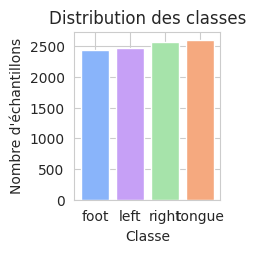

In [21]:
def plot_data_quality_metrics(X, y):
    """
    Métriques de qualité des données inspirées de vos statistiques
    """
    print('-' * 40)
    print("MÉTRIQUES DE QUALITÉ DES DONNÉES")
    print(f"Shape des données: {X.shape}")
    print(f"Min: {np.min(X):.4f}, Max: {np.max(X):.4f}")
    print(f"Moyenne: {np.mean(X):.4f}, Std: {np.std(X):.4f}")
    print(f"Nombre d'échantillons par classe:")


    plt.subplot(2, 3, 5)
    unique, counts = np.unique(y, return_counts=True)
    bars = plt.bar(unique, counts, color=['#89B4FA', '#c6a0f6', '#A6E3AA', '#f5a97f'][:len(unique)])
    plt.title("Distribution des classes")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'échantillons")
    
    min_count, max_count = min(counts), max(counts)
    balance_ratio = min_count / max_count
    print(f"Ratio d'équilibrage des classes: {balance_ratio:.3f}")
    
    if balance_ratio < 0.8:
        print("=> Classes déséquilibrées détectées !")
    else:
        print("=> Classes bien équilibrées")

plot_data_quality_metrics(x_windows[:,:,:,0], y_windows)

## Features complémentaires
On mentionnait plus haut l'activation des bandes de fréquences spécifiques à l'imagerie motrice. Maintenant que nous avons augmenté notre data set, regardons si des patterns par classe apparaissent :


--- EEG Band Power Calculation ---

Traitement de la classe tongue
  - 2608 fenêtres pour la classe tongue
    > fenêtre 1/2608


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 200 is greater than input length  = 50, using nperseg = 50
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


    > fenêtre 51/2608
    > fenêtre 101/2608
    > fenêtre 151/2608
    > fenêtre 201/2608
    > fenêtre 251/2608
    > fenêtre 301/2608
    > fenêtre 351/2608
    > fenêtre 401/2608
    > fenêtre 451/2608
    > fenêtre 501/2608
    > fenêtre 551/2608
    > fenêtre 601/2608
    > fenêtre 651/2608
    > fenêtre 701/2608
    > fenêtre 751/2608
    > fenêtre 801/2608
    > fenêtre 851/2608
    > fenêtre 901/2608
    > fenêtre 951/2608
    > fenêtre 1001/2608
    > fenêtre 1051/2608
    > fenêtre 1101/2608
    > fenêtre 1151/2608
    > fenêtre 1201/2608
    > fenêtre 1251/2608
    > fenêtre 1301/2608
    > fenêtre 1351/2608
    > fenêtre 1401/2608
    > fenêtre 1451/2608
    > fenêtre 1501/2608
    > fenêtre 1551/2608
    > fenêtre 1601/2608
    > fenêtre 1651/2608
    > fenêtre 1701/2608
    > fenêtre 1751/2608
    > fenêtre 1801/2608
    > fenêtre 1851/2608
    > fenêtre 1901/2608
    > fenêtre 1951/2608
    > fenêtre 2001/2608
    > fenêtre 2051/2608
    > fenêtre 2101/2608
    > fenêtr

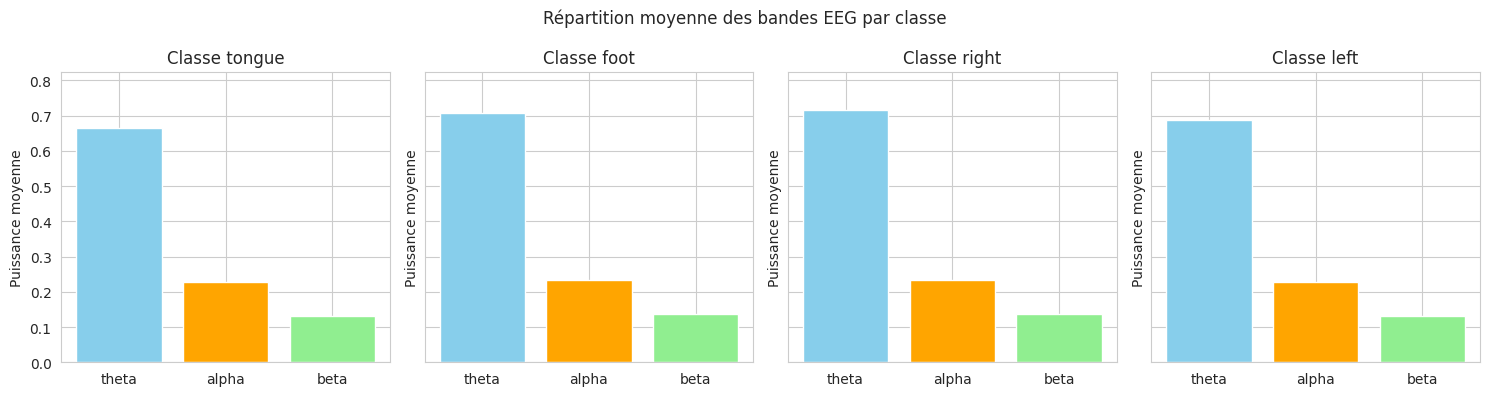

In [22]:
print("\n--- EEG Band Power Calculation ---")

def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
sf = 100
mean_band_power_by_label = {}
band_power_by_label = {label: [] for label in labels}

for c in labels:
    print(f"\nTraitement de la classe {c}")
    x_c = x_windows[y_windows == c][:, :, :, 1]  # Données fréquentielles
    print(f"  - {x_c.shape[0]} fenêtres pour la classe {c}")
    for i, sample in enumerate(x_c):
        if i % 50 == 0:
            print(f"    > fenêtre {i+1}/{x_c.shape[0]}")
        band_powers = {band: [] for band in bands}
        for ch in range(n_channels):
            signal = sample[ch]
            for band, band_range in bands.items():
                bp = bandpower(signal, sf, band_range, window_sec=2)
                band_powers[band].append(bp)
        band_power_by_label[c].append(band_powers)

print("\n--- Moyennes par bande et par classe ---")
for label in labels:
    all_powers = band_power_by_label[label]
    mean_per_band = {}
    print(f"  > Classe {label}")
    for band in bands:
        band_values = [np.mean(sample[band]) for sample in all_powers]
        mean_band = np.mean(band_values)
        mean_per_band[band] = mean_band
        print(f"    - {band}: {mean_band:.4f}")
    mean_band_power_by_label[label] = mean_per_band

fig, axs = plt.subplots(1, len(labels), figsize=(15, 4), sharey=True)
for i, label in enumerate(labels):
    band_names = list(mean_band_power_by_label[label].keys())
    values = list(mean_band_power_by_label[label].values())
    axs[i].bar(band_names, values, color=['skyblue', 'orange', 'lightgreen'])
    axs[i].set_title(f"Classe {label}")
    axs[i].set_ylabel("Puissance moyenne")
    axs[i].set_ylim(0, max(values) * 1.2)
    axs[i].grid(True)

plt.suptitle("Répartition moyenne des bandes EEG par classe")
plt.tight_layout()
plt.show()

**Interprétation**:
- La bande theta domine globalement, ce qui est classique en EEG brut (surtout chez les sujets au repos ou concentrés).

- La bande alpha est stable entre les classes (~0.23), typique du repos occipital mais peut apparaître selon l’état attentionnel.

- La bande beta est logiquement plus faible, ce qui est attendu sans mouvement actif, mais reste légèrement plus élevée pour le pied et la main droite, ce qui pourrait suggérer une implication motrice plus marquée dans ces essais.

## Formattage pré-entraînement

In [23]:
def data_building_features(x_windows, y_categorical):
    """Prépare les données pour les 3 configurations de domaine"""
    
    # Configuration 1: Temporel seul
    x_temporal = x_windows[:, :, :, 0]  # (samples, channels, time_steps)
    x_temporal = x_temporal.transpose(0, 2, 1)  # (samples, time_steps, channels)
    
    # Configuration 2: Fréquentiel seul
    x_frequency = x_windows[:, :, :, 1]  # (samples, channels, freq_bins)
    x_frequency = x_frequency.transpose(0, 2, 1)  # (samples, freq_bins, channels)
    
    # Configuration 3: Combiné
    x_combined = x_windows.transpose(0, 2, 1, 3)  # (samples, time_steps, channels, features)
    x_combined = x_combined.reshape(x_combined.shape[0], x_combined.shape[1], -1)  # (samples, time_steps, channels*features)
    
    return x_temporal, x_frequency, x_combined

x_temporal, x_frequency, x_combined = data_building_features(x_windows, y_categorical)

In [24]:
def get_model_inputs(X_data, y_categorical) :
    # X_train, X_test, y_train, y_test
 return train_test_split(X_data, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# Modèles

In [25]:
def GRU_SIMPLE(input_shape, num_classes, name="GRU_Model"):
    """Modèle GRU simple pour comparaison équitable"""
    inputs = Input(shape=input_shape, name=f"{name}_input")
    x = GRU(128, return_sequences=True, name=f"{name}_gru1")(inputs)
    x = Dropout(0.3, name=f"{name}_dropout1")(x)
    x = GRU(64, name=f"{name}_gru2")(x)
    x = Dropout(0.3, name=f"{name}_dropout2")(x)
    x = Dense(32, activation='relu', name=f"{name}_dense")(x)
    outputs = Dense(num_classes, activation='softmax', name=f"{name}_output")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [27]:
def GRUR(input_shape, num_classes, l2_lambda=0.001, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True, kernel_regularizer=l2(l2_lambda))(inputs)
    dropout_1 = Dropout(dropout_rate)(gru_out)
    flatten_out = Flatten()(dropout_1)
    dropout_2 = Dropout(dropout_rate)(flatten_out)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))(dropout_2)
    return Model(inputs=inputs, outputs=outputs)

In [28]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

## Contrôle de l'apprentissage
### Observations
Au cours des essais, j'ai remarqué que l'apprentissage tardait à se stopper en dépit d'un EarlyStoppig. Celui-ci était attaché à la métrique `accuracy` en mode `max`. On comprend alors que *l'accuracy va croître, au détriment de la perte sur l'ensemble de validation*.

### Corrections apportées
Ainsi, **j'ai substitué l'*earlystopping* sur l'`accuracy` par l'*ES* sur la perte**. En conséquence, l'apprentissage est plus pertinent, certes moins prédictif sur l'ensemble d'entrainement (85% d'accuracy contre 90% et des poussières) **mais se généralise davantage**.

### Enseignements
Rien ne sert de persister inutillement sur l'apprentissage s'il évolue dans des dynamiques tendancieuses. À savoir que l'`accuracy` peut rester stable et la perte augmenter. Concrètement, cela signifie que si le modèle prédit *les bonnes classes*, il le faut d'*autant moins bien qu'il surapprend*. En effet :
- l’`accuracy` reste stable, mais avec moins de confiance (ex. 0.51 au lieu de 0.95). La **`loss` augmente car la distance aux one-hot vectors est plus grande**.
- le modèle fait quelques erreurs, chacune avec une grande probabilité prédite, la `loss` est drastiquement impactée tandis que l'`accuracy` demeure convenable.

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               mode='min') # Endroit de la substitution
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)

## Entraînement
### Feature temporelle uniquement

2025-06-19 05:57:17.556341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "GRU_Model_Temporal"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_Model_Temporal_input             │ (None, 50, 22)              │               0 │
│ (InputLayer)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_gru1 (GRU)        │ (None, 50, 128)             │          58,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_dropout1          │ (None, 50, 128)             │               0 │
│ (Dropout)                            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_gru2 (GRU)        │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_dropout2          │ (None, 64)                  │               0 │
│ (Dropout)                            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_dense (Dense)     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Temporal_output (Dense)    │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,828 (382.14 KB)

 Trainable params: 97,828 (382.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.2518 - loss: 1.4036 - val_accuracy: 0.2620 - val_loss: 1.3860 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.2824 - loss: 1.3860 - val_accuracy: 0.2600 - val_loss: 1.3888 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.2870 - loss: 1.3805 - val_accuracy: 0.2511 - val_loss: 1.3915 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.2820 - loss: 1.3807 - val_accuracy: 0.2689 - val_loss: 1.3888 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.2970 - loss: 1.3742 - val_accuracy: 0.2645 - val_loss: 1.3871 - learning_rate: 2.5000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.3012 - loss: 1.3708 - val_accuracy: 0.2704 - val_loss: 1.3844 - learning_rate: 2.5000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 7

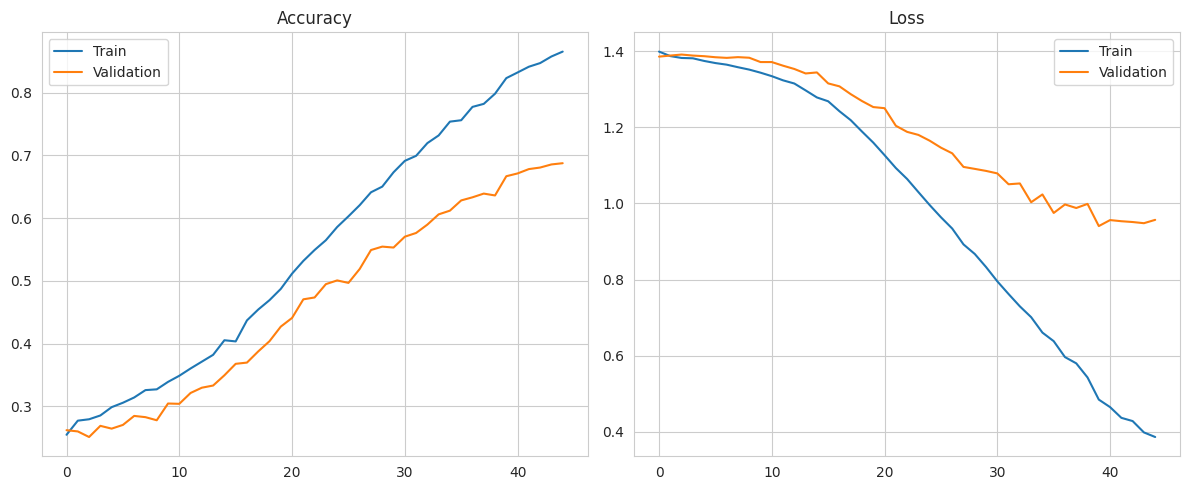

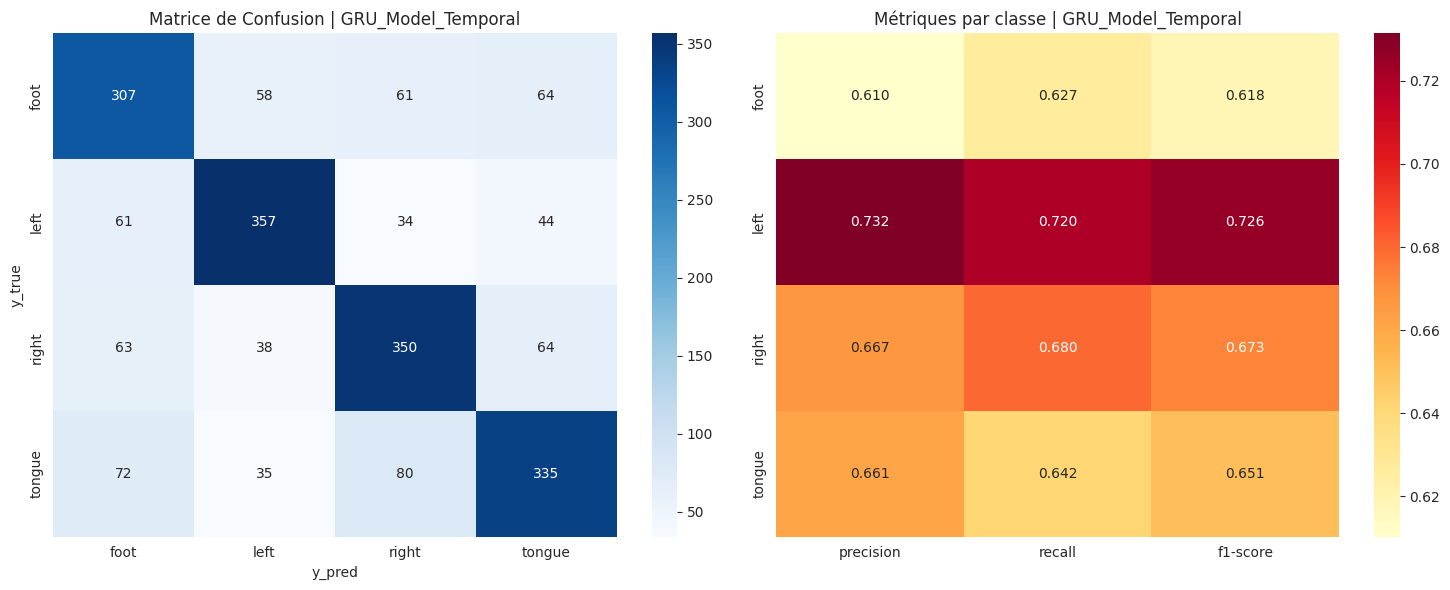

({'accuracy': 0.6668314384577361,
  'f1_macro': 0.6670331417885476,
  'f1_weighted': 0.6670298084012065,
  'precision_macro': 0.6673278806965495,
  'recall_macro': 0.6669156948384358},
         precision    recall  f1-score
 foot     0.610338  0.626531  0.618328
 left     0.731557  0.719758  0.725610
 right    0.666667  0.679612  0.673077
 tongue   0.660750  0.641762  0.651118)

In [30]:
X_train, X_test, y_train, y_test = get_model_inputs(x_temporal, y_categorical)
channels = x.shape[1]
timesteps = X_train.shape[1] 
features = X_train.shape[2]        
num_classes = y_train.shape[1]     
model = GRU_SIMPLE(input_shape=(timesteps, channels), num_classes=num_classes, name="GRU_Model_Temporal")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = "GRU_Model_Temporal")

#### Conclusions
- **Hypothèse / Justification** : On suppose que la composante temporelle des signaux EEG est porteuse d'information discriminante entre les classes de mouvements imaginés (foot, left, right, tongue). La question, c'est "dans quelle mesure ?". L'objectif est de vérifier si un modèle GRU est capable de capter cette dynamique.

- **Méthodologie** : Utilisation du modèle GRU_SIMPLE avec deux couches GRU (128, puis 64 unités), Dropout (30%) et une couche dense. Les données d’entrée sont uniquement temporelles (x_temporal). Données EEG prétraitées, normalisées, split train/val/test.

- **Observations** :
    - `Accuracy` : ~64.2%
    - `F1 macro` : ~64.3%
    - Meilleure performance pour `left` (f1 = 0.75), plus faible pour `foot` (~0.55).
    - Modèle stable et équilibré, mais encore perfectible.

- **Conclusions et Décisions** : Le signal temporel semble contenir une information pertinente. Le modèle capte correctement certaines classes mais a des difficultés à généraliser sur toutes. On décidera de tester une autre représentation (fréquentielle) pour comparer.

### Feature fréquentielle uniquement

Model: "GRU_Model_Frequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_Model_Frequential_input          │ (None, 50, 22)              │               0 │
│ (InputLayer)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_gru1 (GRU)     │ (None, 50, 128)             │          58,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_dropout1       │ (None, 50, 128)             │               0 │
│ (Dropout)                            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_gru2 (GRU)     │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_dropout2       │ (None, 64)                  │               0 │
│ (Dropout)                            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_dense (Dense)  │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Frequential_output (Dense) │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,828 (382.14 KB)

 Trainable params: 97,828 (382.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.2474 - loss: 1.3868 - val_accuracy: 0.2546 - val_loss: 1.3862 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.2548 - loss: 1.3864 - val_accuracy: 0.2580 - val_loss: 1.3864 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.2566 - loss: 1.3863 - val_accuracy: 0.2580 - val_loss: 1.3863 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.2544 - loss: 1.3866 - val_accuracy: 0.2546 - val_loss: 1.3862 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.2585 - loss: 1.3858 - val_accuracy: 0.2580 - val_loss: 1.3861 - learning_rate: 2.5000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.2589 - loss: 1.3861 - val_accuracy: 0.2580 - val_loss: 1.3860 - learning_rate: 2.5000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 7

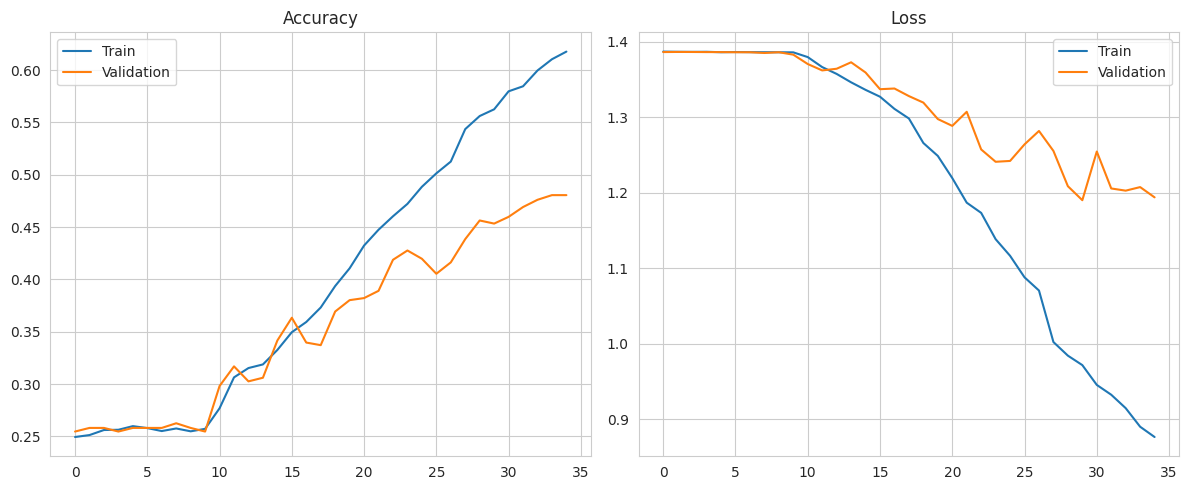

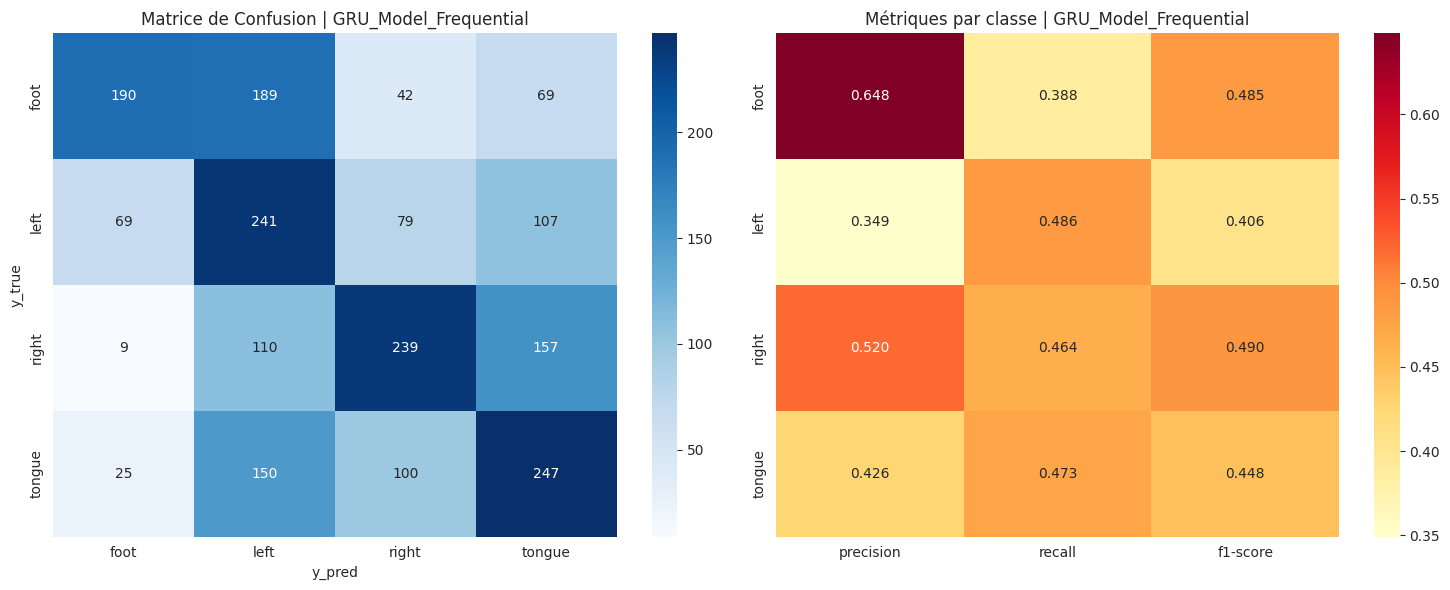

({'accuracy': 0.4532871972318339,
  'f1_macro': 0.4575633164666135,
  'f1_weighted': 0.4576687032544687,
  'precision_macro': 0.48579170312454695,
  'recall_macro': 0.4527249863365687},
         precision    recall  f1-score
 foot     0.648464  0.387755  0.485313
 left     0.349275  0.485887  0.406408
 right    0.519565  0.464078  0.490256
 tongue   0.425862  0.473180  0.448276)

In [31]:
X_train, X_test, y_train, y_test = get_model_inputs(x_frequency, y_categorical)
channels = x.shape[1]
freq_bins = X_train.shape[1] 
features = X_train.shape[2]        
num_classes = y_train.shape[1]     
model = GRU_SIMPLE(input_shape=(freq_bins, channels), num_classes=num_classes, name="GRU_Model_Frequential")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = "GRU_Model_Frequential")

#### Conclusions
- **Hypothèse / Justification** : On veut tester si la feature fréquentielle (calculée avec FFT) peut améliorer la discrimination des signaux EEG, car certaines bandes de fréquence sont associées à des tâches motrices. Par ailleurs, il est intéressant de voir comment celle-ci se positionne comparativement à la feature temporelle. 

- **Méthodologie** : On conserve le modèle GRU_SIMPLE par soucis d'équité !

- **Observations** :
    - `Accuracy` : ~50%
    - `F1 macro` : ~49.9%
    - Perte importante de performance pour `left` (f1 = 0.37), et résultat global proche du hasard (4 classes).
    - `right` est la mieux reconnue (~0.57).

- **Conclusions et Décisions** : L'utilisation de la composante fréquentielle est assez décevante, non sans une certaine surprise, mais - quoiqu'elle soit porteuse d'information, notamment sur la main droite - il faut envisager le couplage comme le salut de notre prétraitement.

- **Perspectives** : Un prétraitement plus poussé de la composante temporelle avec une transformée de Fourier à court terme serait certainement plus intéressant. À tester. 

### Couplage temps / fréquence

Model: "GRU_Model_Both"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_Model_Both_input (InputLayer)    │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_gru1 (GRU)            │ (None, 50, 128)             │          66,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_dropout1 (Dropout)    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_gru2 (GRU)            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_dropout2 (Dropout)    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_dense (Dense)         │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Model_Both_output (Dense)        │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,276 (415.14 KB)

 Trainable params: 106,276 (415.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.2472 - loss: 1.3986 - val_accuracy: 0.2694 - val_loss: 1.3883 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.2691 - loss: 1.3872 - val_accuracy: 0.2590 - val_loss: 1.3884 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.2648 - loss: 1.3857 - val_accuracy: 0.2659 - val_loss: 1.3923 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.2832 - loss: 1.3816 - val_accuracy: 0.2640 - val_loss: 1.3874 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.2847 - loss: 1.3781 - val_accuracy: 0.2892 - val_loss: 1.3838 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.3056 - loss: 1.3738 - val_accuracy: 0.2783 - val_loss: 1.3791 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 7

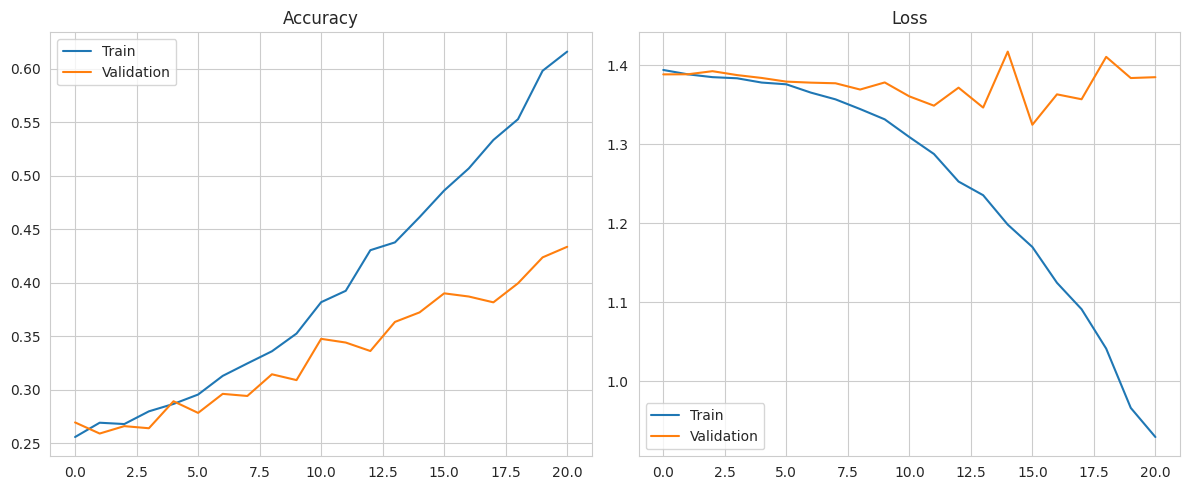

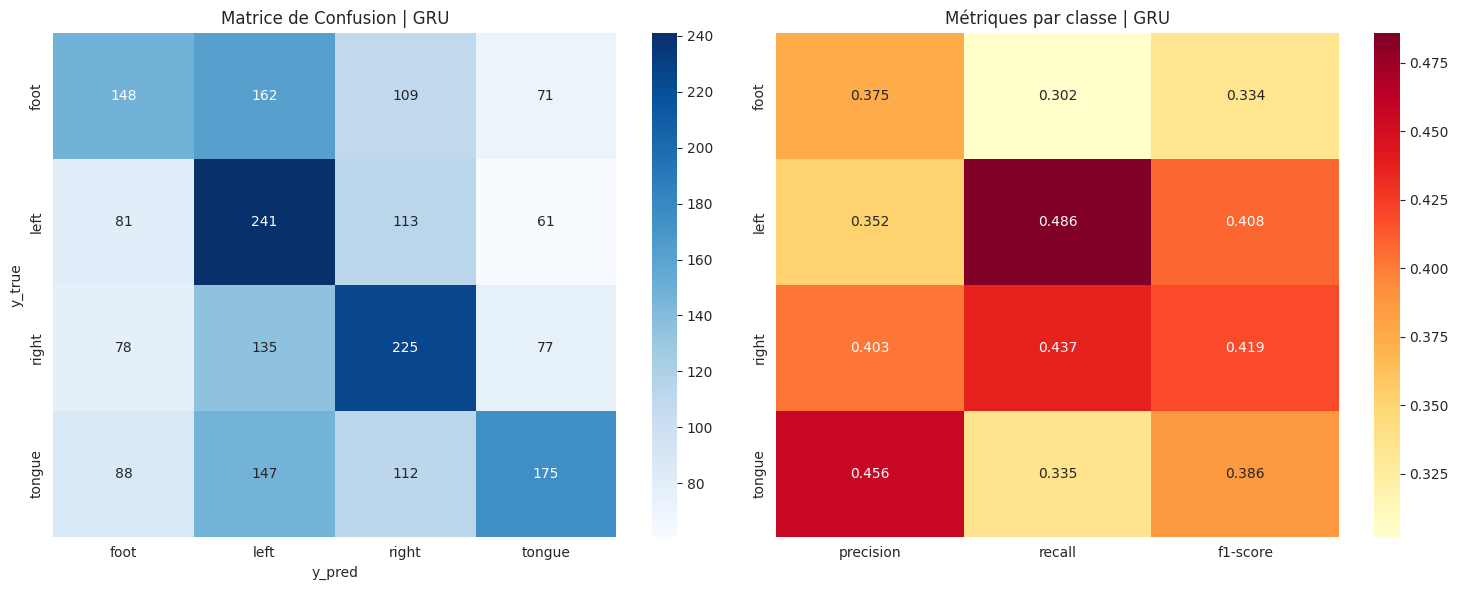

({'accuracy': 0.39001482946119626,
  'f1_macro': 0.3869749651288415,
  'f1_weighted': 0.38742293382092363,
  'precision_macro': 0.39618550019015664,
  'recall_macro': 0.3900175397824533},
         precision    recall  f1-score
 foot     0.374684  0.302041  0.334463
 left     0.351825  0.485887  0.408129
 right    0.402504  0.436893  0.418994
 tongue   0.455729  0.335249  0.386313)

In [32]:
X_train, X_test, y_train, y_test = get_model_inputs(x_combined, y_categorical)
channels = x.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4
MODEL_TYPES = ["GRU", "GRUR", "CNN_LSTM"]
MODEL_TYPE = "GRU"
model = GRU_SIMPLE(input_shape=(timesteps, features), num_classes=num_classes, name="GRU_Model_Both")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = MODEL_TYPE)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.2633 - loss: 1.5684 - val_accuracy: 0.3000 - val_loss: 1.4213 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.3824 - loss: 1.3271 - val_accuracy: 0.3085 - val_loss: 1.4024 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.4373 - loss: 1.2316 - val_accuracy: 0.3435 - val_loss: 1.3706 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.4975 - loss: 1.1403 - val_accuracy: 0.3717 - val_loss: 1.3560 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.5646 - loss: 1.0347 - val_accuracy: 0.4019 - val_loss: 1.3283 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.6548 - loss: 0.8663 - val_accuracy: 0.4558 - val_loss: 1.2986 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 9

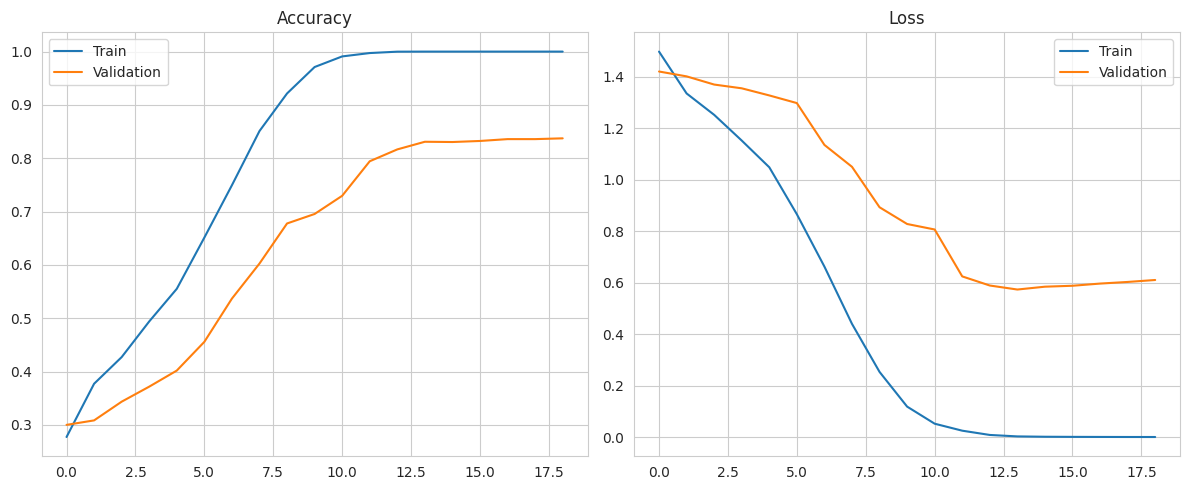

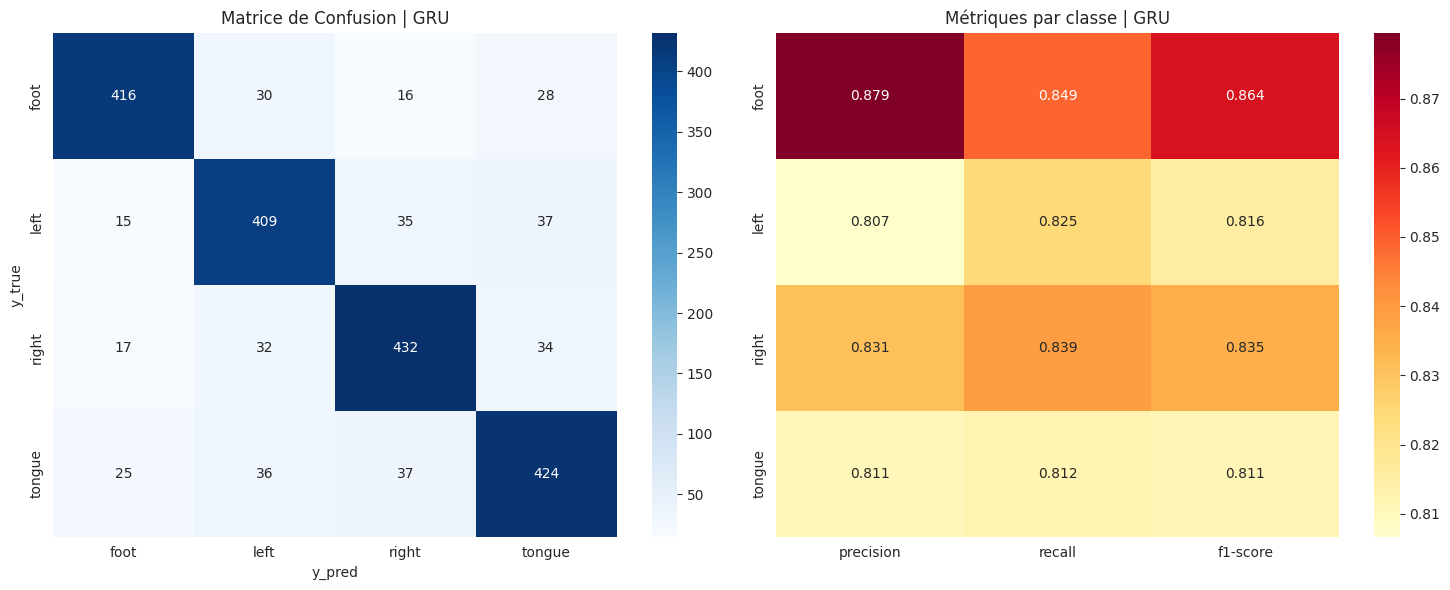

({'accuracy': 0.8309441423628274,
  'f1_macro': 0.8314464931932637,
  'f1_weighted': 0.8311248027834411,
  'precision_macro': 0.8319188506423634,
  'recall_macro': 0.8311679634712652},
         precision    recall  f1-score
 foot     0.879493  0.848980  0.863967
 left     0.806706  0.824597  0.815553
 right    0.830769  0.838835  0.834783
 tongue   0.810707  0.812261  0.811483)

In [33]:
X_train, X_test, y_train, y_test = get_model_inputs(x_combined, y_categorical)
channels = x.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4
MODEL_TYPES = ["GRU", "GRUR", "CNN_LSTM"]
MODEL_TYPE = "GRU"
model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = MODEL_TYPE)

#### Conclusions

- **Hypothèse / Justification** : La composante fréquentielle est un peu faîble, forcir la composante temporelle au niveau du modèle semble porteur. L'association des deux devrait augmenter les performances du modèle.
- **Méthodologie** :
Modèle GRU_Flatten_Model avec une seule couche GRU à 256 unités pour capter une dynamique temporelle plus importante, puis aplatissement (flatten) et softmax. Optimiseur Adam, entraînement avec early stopping et validation.
- **Observations** :
    - `Accuracy val` : 83.6%
    - Toutes les métriques (`precision`, `recall`, `f1`) >= 0.80
    - Apprentissage très rapide (`loss` proche de 0 sur train), bonne généralisation.
    - Overfitting persistant (`loss val` - `train val` = 0.6) -> à travailler

**Conclusions et Décisions** : L'architecture suivante sur les données aux features combinées est très performantes. Plus que ce à quoi je m'attendais. Le Flatten semble jouer un rôle utile en consolidant l’information temporelle extraite. Même si j'ai connaissance des papiers sur les LSTM, délayer des architectures à fort contexte temporel (empilement de GRU, attention, combinaisons temps/fréquence...) semble être une excellente solution.

### Modèle GRU régularisé
En introduisant la régularisation, on espère réduire cet overfitting résiduel qui gache un peu notre modèle. On part sur des valeurs usuelles en combinant un `dropout` avec la régularisation L2 pour accroître la robustesse du modèle.

***Remarque** : Il est vrai que le jeu de données n'est pas très grand non plus...*

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.2610 - loss: 1.9237 - val_accuracy: 0.3030 - val_loss: 1.4778 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.3107 - loss: 1.5652 - val_accuracy: 0.3183 - val_loss: 1.4487 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.3493 - loss: 1.4646 - val_accuracy: 0.3347 - val_loss: 1.4199 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.3539 - loss: 1.4296 - val_accuracy: 0.3480 - val_loss: 1.4110 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.3841 - loss: 1.3956 - val_accuracy: 0.3386 - val_loss: 1.4092 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.3923 - loss: 1.3755 - val_accuracy: 0.3609 - val_loss: 1.3947 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 9

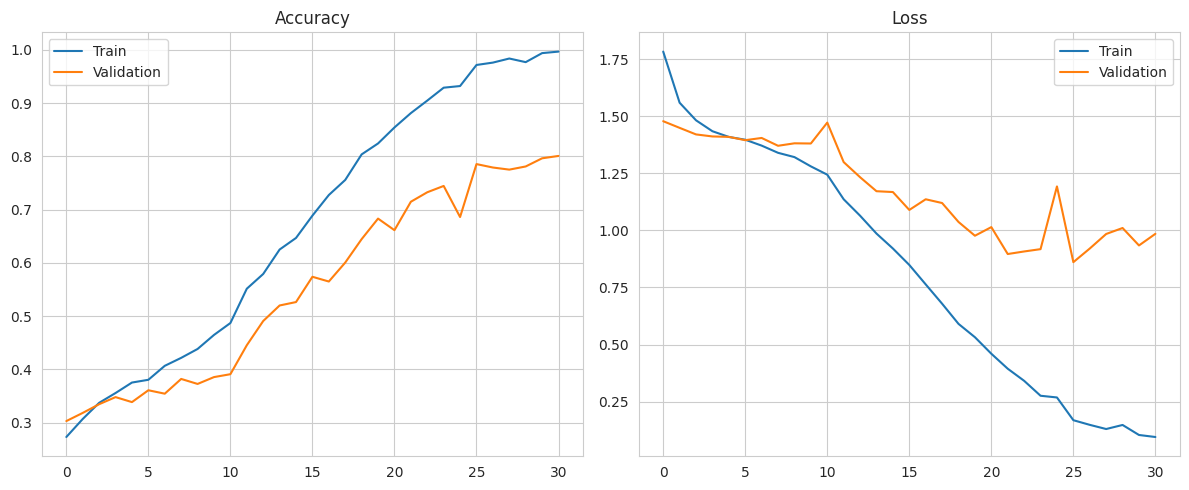

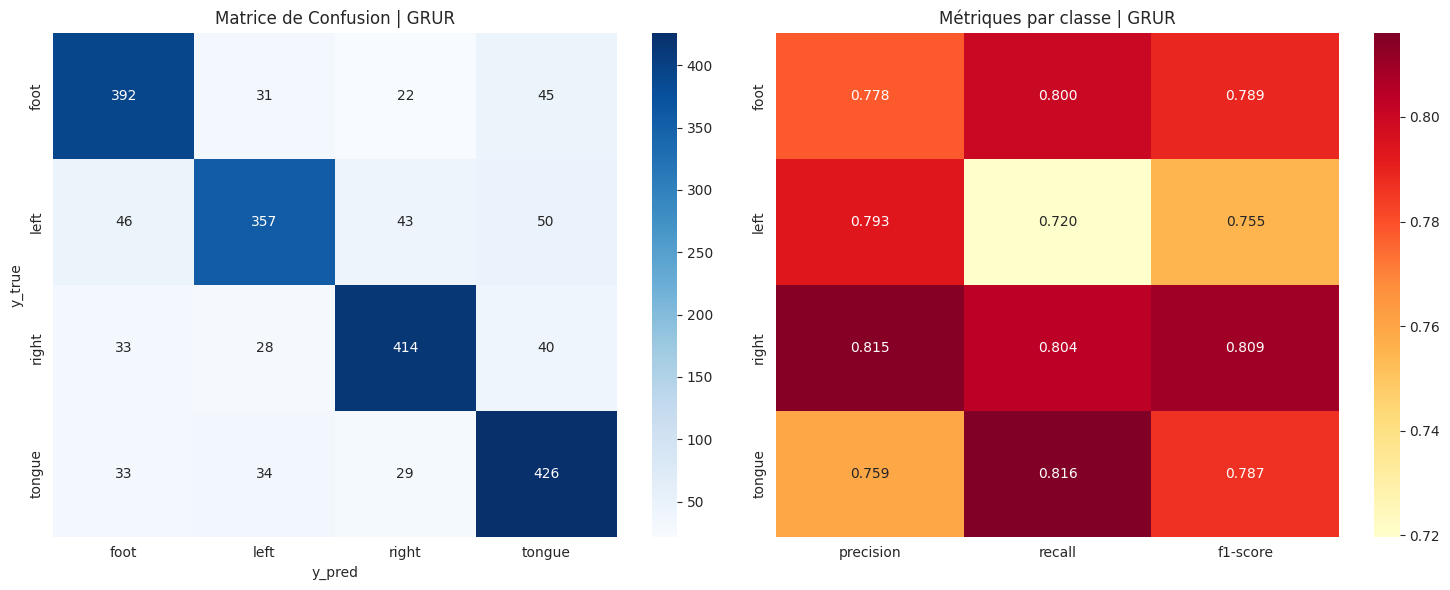

({'accuracy': 0.7854671280276817,
  'f1_macro': 0.7848942576832613,
  'f1_weighted': 0.7851361372350155,
  'precision_macro': 0.7863575074506061,
  'recall_macro': 0.7849333784211872},
         precision    recall  f1-score
 foot     0.777778  0.800000  0.788732
 left     0.793333  0.719758  0.754757
 right    0.814961  0.803883  0.809384
 tongue   0.759358  0.816092  0.786704)

In [34]:
model = GRUR(input_shape=(timesteps, features),num_classes=num_classes)
MODEL_TYPE = "GRUR"
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = MODEL_TYPE)

**Observations** : Le modèle est bon, à n'en pas douter, mais peut-être pas aussi bon qu'espéré ; et surtout, légèremement moins précis que le précédent *sauf pour le pied*. Ainsi, si la régularisation nous permet de dépasser un léger overfitting sur le pied, elle freine malheureusement l'apprentissage de certaines structures plus fines sur les autres classes.

**Moralité** : S'il y a un compromis à trouver, ce n'est peut-être pas nécessairement sur la régularisation en l'état. On manque peut-être de profondeur pour passer le cap des 90% d'accuracy. 

### CNN-LSTM
Nos données fréquentielles demeurent intéressantes dans la mesure où nous avons des corrélations locales entre les canaux. Nous l'avons vu au cours du prétraitement. La composante temporelle est indéniablement indispensable, c'est certain. Le GRU avait l'avantage d'être plus léger qu'une architecture LSTM ; toutefois, il peut être intéressant de se pencher désormais sur des architectures plus complexes
- **Hypothèse** : Convoluer sur les données fréquentielles pour dégager des patterns spatiaux, puis les injecter dans un LSTM (traitement temporel), afin d'exploiter les deux dimensions. Le modèle vise à être polymorphe, capable d’extraire à la fois des motifs locaux (via CNN) et des dynamiques temporelles (via LSTM). 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 50, 32)              │           4,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 25, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,492 (638.64 KB)

 Trainable params: 163,300 (637.89 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.2546 - loss: 1.6736 - val_accuracy: 0.2739 - val_loss: 1.6029 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.2583 - loss: 1.5948 - val_accuracy: 0.2570 - val_loss: 1.5501 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.2660 - loss: 1.5404 - val_accuracy: 0.2610 - val_loss: 1.5092 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2776 - loss: 1.5011 - val_accuracy: 0.2921 - val_loss: 1.4658 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.2837 - loss: 1.4672 - val_accuracy: 0.2892 - val_loss: 1.4591 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.2853 - loss: 1.4444 - val_accuracy: 0.2916 - val_loss: 1.4424 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 4

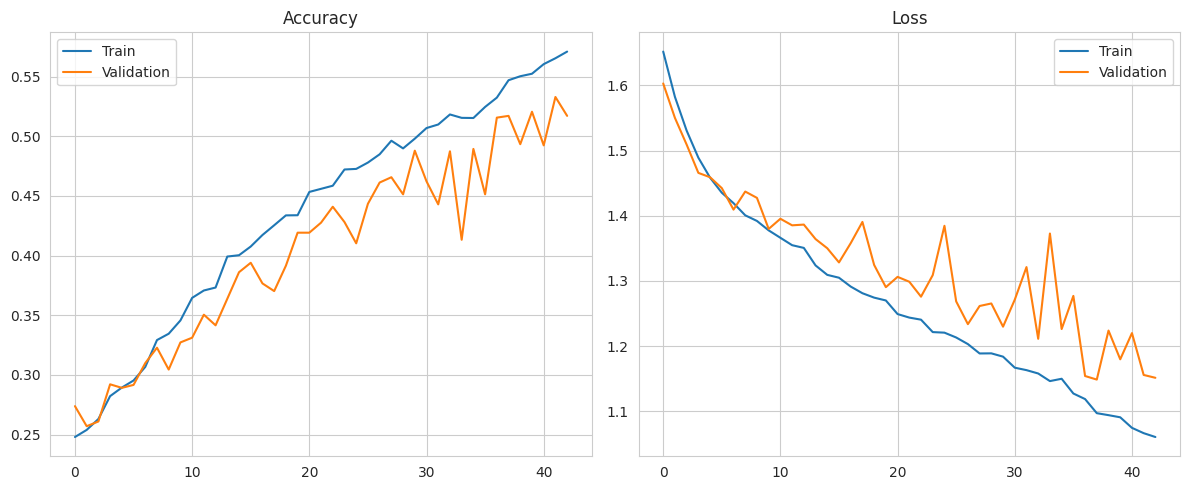

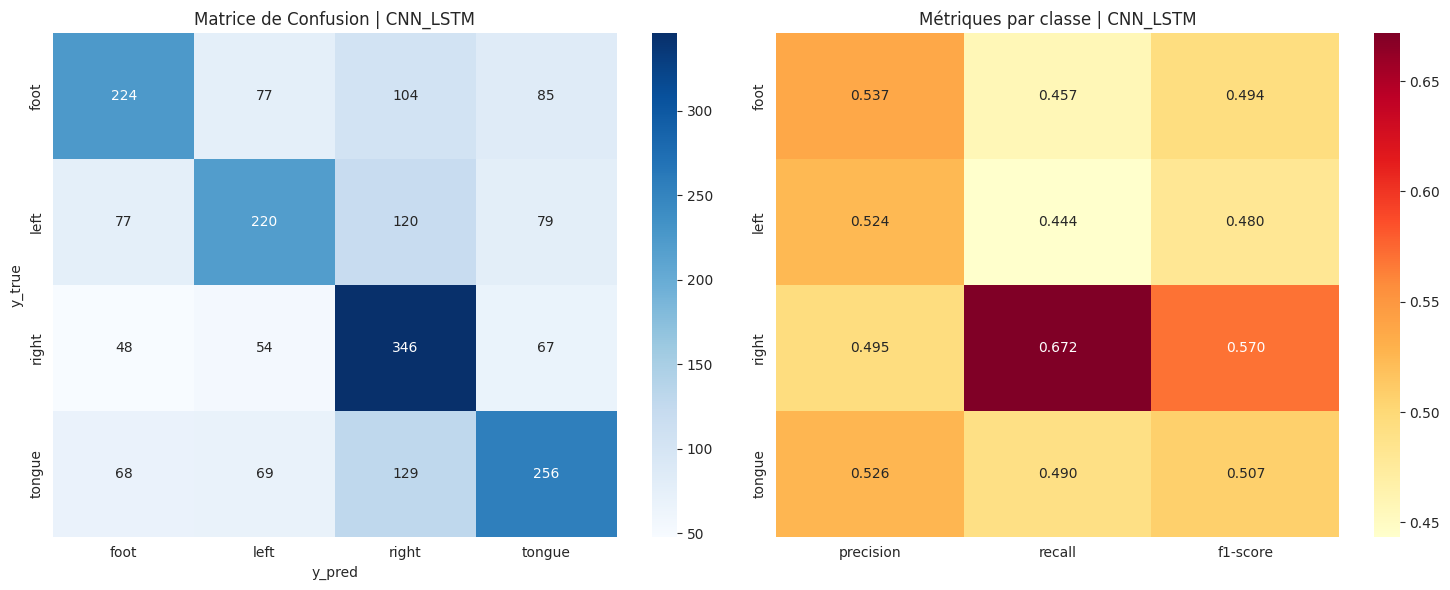

({'accuracy': 0.5170538803756797,
  'f1_macro': 0.5129337436114336,
  'f1_weighted': 0.5134555139280741,
  'precision_macro': 0.5204099964130084,
  'recall_macro': 0.5157393400931258},
         precision    recall  f1-score
 foot     0.537170  0.457143  0.493936
 left     0.523810  0.443548  0.480349
 right    0.494993  0.671845  0.570016
 tongue   0.525667  0.490421  0.507433)

In [35]:
model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes)
MODEL_TYPE = "CNN_LSTM"
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, lr_scheduler],
                verbose=1)
training_bahaviour(history)
evaluate_model(model, X_test, y_test, label_encoder, model_name = MODEL_TYPE)

- **Idée** : L'objectif était de mettre l'accent sur la dynamique fréquentielle au long court.
- **Observations** : Échec d'apprentissage avec une `accuracy`à 49 % ; quoiqu'une précision de 62% sur `foot`.
- **Hypothèses** :
    - Données convoluées trop pauves ?
    - Pénalisation trop forte ?
- **Perspectives** :
    - Retirer des dropouts et la régularisation, et les ajouter progressivement.
    - Augmenter les features fréquentielles
    - Augmenter les dimensions des kernels pour capter davantage d'information

# Synthèse et perspectives
## Conclusion
Un soin et un attention ont été donné à la partie préprocessing car cruciale dans l'élaboration d'un modèle de machine learning. On y a découvert la polysémie des prétraitements réalisables, et l'enjeu conséquentiel à l'exhibition de features appropriées. Pour mieux comprendre l'impact de ces dernières sur l'apprentissage, il était intéressant de comparer les résultats qu'offre un même modèle sur celles-ci de façon respectives. Pour ce faire, le modèle GRU, léger et peu complexe, s'est révélé très performant en atteignant une précision de près de 64% pour les features temporelles contre 50% pour les features fréquentielles.

Fort de cette expérience, il semble indiqué de poursuivre le prétraitement des données pour mettre au jours de plus amples features fréquentielles ; lesquelles sont à combiner dans un espace temporel dénotant une importante information sur les données. 

Pour améliorer les perfomances du modèle combiné, nous avons essayé d'adjoindre une régularisation L2 et un dropout afin de prévenir tout overfitting ; mais cela s'est révelé peu voire pas efficace. Le GRU avec flatten sans régularisation s'est révêlé être le meilleur modèle, avec une précision impressionnante.

Enfin, la tentative d'architecture un peu plus complexes et lourde (CNN-LSTM) s'est soldée par un résultat très moyen faute de profondeur. C'est une piste à explorer, sous couvert d'un prétraitement approfondi et d'un apprentissage parcimonieux

## Perpectives
L'enjeu est d'aborder des architectures plus complexes, mais surtout plus gourmandes en ressources comme 3D-CLMI qui ne nécessitent pas de délayer de features, et qui malgré tout excellent. Je pense qu'il peut être intéressant de déployer les techniques de preprocessing fréquentiels.

# Bibliographie
- shariharan205. (s.d.). Motor-Imagery-Tasks-Classification-using-EEG-data: Implementation of Deep Neural Networks in Keras and Tensorflow to classify motor imagery tasks using EEG data
- dépôt GitHub public appartenant à "shariharan205" qui implémente des réseaux neuronaux profonds (CNN, RNN, LSTM, GRU et RNN bidirectionnels) avec Keras et TensorFlow pour la classification des tâches d'imagerie motrice à partir de données EEG
- Wang, D., Miao, D., & Blohm, G. (2012). Multi-Class Motor Imagery EEG Decoding for Brain-Computer Interfaces. Frontiers in Neuroscience, 6, 151. DOI: 10.3389/fnins.2012.00151
- Documentation MNE-Python (Analyse MEG/EEG)
- MNE-Python contributors. (s.d.). Overview of MEG/EEG analysis with MNE-Python. MNE 1.9.0 documentation
- Documentation MNE-Python (Détection des artefacts)
- Cheng, S., & Hao, Y. (s.d.). 3D-CLMI: A Motor Imagery EEG Classification Model via Fusion of 3D-CNN and LSTM with Attention
- Brunner, C., Leeb, R., Müller-Putz, G. R., Schlögl, A., & Pfurtscheller, G. (2008). BCI Competition 2008 – Graz data set A. Institute for Knowledge Discovery, Graz University of Technology, Austria
